## License 

Copyright 2020 Patrick Hall (jphall@gwu.edu)

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

**DISCLAIMER:** This notebook is not legal compliance advice.

### Introduction

Kaggle Compete - Titanic: Machine Learning from Disaster: 

**URL**: https://www.kaggle.com/c/titanic/data

**Leaderboard**: https://www.kaggle.com/c/titanic/leaderboard

**Teamname**: SeanFan

**Project Background Intro**: This Kaggle Compete Titanic dataset was colleceted from the famous shipwrecks diaster "The Sinking of the Royal Mail Ship Titanic" happen on April 14-15, 1912, during its maiden voyage, enroute to New York City from Southampton, England. However, after shi ship wrecked, there were not enought lifeboats for all passengers, which resulting in the death of 1502 out of 2224 passengers and crew.

**The Challenge Goal**: using known passenger's features to establish predictive model to predict what types of passenger have higher possibility of surivial?

**Kaggle provides two datasets**: Train and Test, but the Test dataset is provided for the purpose of prediction accuracy competition without reponse variable `Survived`. Therefore, we decided to split the original Train dataset with **70%** as sub_train dataset and **30%** as sub_valid dataset.

There are 12 variables included in original Train dataset:
* **`PassengerID`**: The index of each passenger.
* **`Survived`**: 0 = Not survived, 1 = Survived.
* **`Pclass`**: Ticket class; 1 = 1st, 2 = 2nd, 3 = 3rd.
* **`Name`**: Passengers' full name with prefix.
* **`Sex`**: Passengers' gender.
* **`Age`**: Passengers' Age.
* **`SibSip`**: # of sibiling / spouses aboard the Titanic.
* **`Parch`**: # of parents / children aboard the Titanic.
* **`Ticket`**: Ticket number.
* **`Fare`**: Passengers' ticket fare.
* **`Cabin`**: Cabin number.
* **`Embarked`**: Port of Embarkation; C = Cherbourg, Q = Queenstown, S = Southampton.

### Global hyperpameters

In [1]:
SEED                    = 12345   # global random seed for better reproducibility
GLM_SELECTION_THRESHOLD = 0.005   # threshold above which a GLM coefficient is considered "selected"

### Python imports and inits

In [2]:
from rmltk import explain, evaluate, model                        # simple module for training, explaining, and eval
from scipy.special import expit                                   # for inverse logit

import h2o                                                        # import h2o python bindings to h2o java server
from h2o.estimators.gbm import H2OGradientBoostingEstimator      # for GBM
import numpy as np                                                # array, vector, matrix calculations
import operator                                                   # for sorting dictionaries
import pandas as pd                                               # DataFrame handling
import time                                                       # for timers
import shap                                                       # for visualizing Shapley values 
import xgboost as xgb

# enables display of images in notebook
from IPython.display import Image
from IPython.display import display

import matplotlib.pyplot as plt      # plotting
pd.options.display.max_columns = 999 # enable display of all columns in notebook

# enables display of plots in notebook
%matplotlib inline

np.random.seed(SEED)                     # set random seed for better reproducibility

h2o.init(max_mem_size='24G', nthreads=4) # start h2o with plenty of memory and threads
h2o.remove_all()                         # clears h2o memory
h2o.no_progress()                        # turn off h2o progress indicators    

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.251-b08, mixed mode)
  Starting server from S:\Anaconda\Anaconda3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\yuxia\AppData\Local\Temp\tmpsc9t9e9e
  JVM stdout: C:\Users\yuxia\AppData\Local\Temp\tmpsc9t9e9e\h2o_yuxia_started_from_python.out
  JVM stderr: C:\Users\yuxia\AppData\Local\Temp\tmpsc9t9e9e\h2o_yuxia_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.3
H2O_cluster_version_age:,1 month and 13 days
H2O_cluster_name:,H2O_from_python_yuxia_x7dcpu
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.33 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


# 1. Preparation and Import Train Dataset

### 1.1 EDA & Data Cleaning:
**1.** All these processes were done in RStudio since we needed tohave create other simpler models with easier steps. We checked serval aspects such as the density of histogram on the variable `Age` and `Fare`. We also tried to discover the Survived ratio by different variables: `Sex`, `Pclass`, and `Embarked`, etc.

**2.** During data cleaning process, we removed some variables that we think are not significant features: `Ticket`, `Fare`, `Cabin` and `Embarked`. We also replace `Sex` with male = 0 and female = 1 as a dummy/qualitative variable for future modeling convenience.

**3.** We replaced passengers' `Name` with their prefix as categorical variable, made inference on missing values in `Age` based on the title-group average ages, and made inference on missing values in `Pclass` based on the fare-group average expenses. (`PassengerID` was removed for convenience, but since we need this variable in the following modeling process, we added it back).

**4.** We also create three new variables as potential features for improving our prediction accuracy (since the code "Women and Children First")  :
* `Family`: The size of family of passengers as sum of # of SibSp and # of Parch.
* `Mother`: The passenger who her/his prefix is "Mrs" and # of Parch > 0, is mother = 1, not a mother = 2.
* `Child`: Passengers' age under 12 years old. under 12 = 1, older than 12 = 2.

**5.** Eventually, our cleaned Train dataset only contains variables included: `Pclass`, `Survived`, `Name`, `Sex`, `Age`, `Sibsip`, `Parch`, `Fare`, `Title`, `Family`, `Mother` and `Child`.

### 1.2 Import cleaned train datasets

In [3]:
TitanicData = pd.read_csv('train_clean.csv')

### 1.3 Add PassengerID as index of each row/observation

In [4]:
TitanicData['PassengerID'] = None
TitanicData['PassengerID'] = TitanicData.index+1
TitanicData['Age'] = round(TitanicData['Age'],0).astype(np.int64)

#### Take a look at the metadata of entire dataset

In [5]:
TitanicData.describe()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Family,Mother,Child,PassengerID
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,0.352413,29.837262,0.523008,0.381594,32.204208,1.904602,0.062851,0.081930,446.000000
std,0.486592,0.836071,0.477990,13.279849,1.102743,0.806057,49.693429,1.613459,0.242831,0.274413,257.353842
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
25%,0.000000,2.000000,0.000000,22.000000,0.000000,0.000000,7.910400,1.000000,0.000000,0.000000,223.500000
50%,0.000000,3.000000,0.000000,30.000000,0.000000,0.000000,14.454200,1.000000,0.000000,0.000000,446.000000
75%,1.000000,3.000000,1.000000,36.000000,1.000000,0.000000,31.000000,2.000000,0.000000,0.000000,668.500000
max,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000,512.329200,11.000000,1.000000,1.000000,891.000000


### 1.4 Import Kaggle Test Dataset (Only for Kaggle compete use)

In [6]:
test = pd.read_csv("test_clean.csv")

### 1.5 Assign Modeling Roles

In [7]:
y_name = 'Survived'
x_names = [name for name in TitanicData.columns if name not in [y_name,'Name', 'SibSp','Parch','Title']]

print('Response variable = %s' % y_name)
print('Independent variables = %s' % x_names)

Response variable = Survived
Independent variables = ['Pclass', 'Sex', 'Age', 'Fare', 'Family', 'Mother', 'Child', 'PassengerID']


In [8]:
TitanicData[x_names + [y_name]].describe()

,Pclass,Sex,Age,Fare,Family,Mother,Child,PassengerID,Survived
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,2.308642,0.352413,29.837262,32.204208,1.904602,0.062851,0.081930,446.000000,0.383838
std,0.836071,0.477990,13.279849,49.693429,1.613459,0.242831,0.274413,257.353842,0.486592
min,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,2.000000,0.000000,22.000000,7.910400,1.000000,0.000000,0.000000,223.500000,0.000000
50%,3.000000,0.000000,30.000000,14.454200,1.000000,0.000000,0.000000,446.000000,0.000000
75%,3.000000,1.000000,36.000000,31.000000,2.000000,0.000000,0.000000,668.500000,1.000000
max,3.000000,1.000000,80.000000,512.329200,11.000000,1.000000,1.000000,891.000000,1.000000


# 2. Investigate Pair-wise Pearson Correlations

The check and understand the relationship between Independent Variables and Response Variables, or the relationship between Input and Prediction. In the following, pearson correlation will be applied to understaning this relationship before considering modeling. 

### 2.1 Calculate Pearson correlation

In [9]:
corr = pd.DataFrame(TitanicData[x_names + [y_name]].corr()[y_name]).iloc[:-1]
corr.columns = ['Pearson Correlation Coefficient']
corr

,Pearson Correlation Coefficient
Pclass,-0.338481
Sex,0.543351
Age,-0.091173
Fare,0.257307
Family,0.016639
Mother,0.175967
Child,0.117636
PassengerID,-0.005007


### 2.2 Plot Pearson correlation

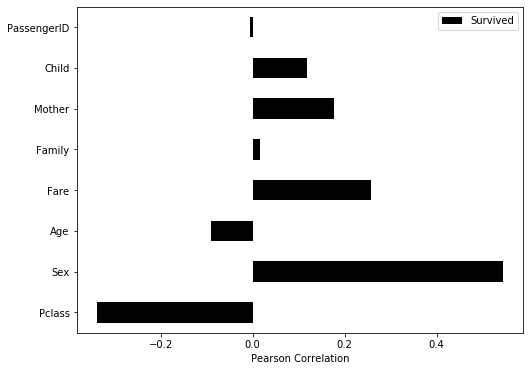

In [10]:
# display correlation to target as barchart
fig, ax_ = plt.subplots(figsize=(8, 6))
_ = pd.DataFrame(TitanicData[x_names + [y_name]].corr()[y_name]).iloc[:-1].plot(kind='barh', ax=ax_, colormap='gnuplot')
_ = ax_.set_xlabel('Pearson Correlation')

By looking at this plot of Pearson Correlation between `Survived` and all input variables, `Sex` is the most correlated to `Survived` with positive correlation, which indicates the "Women first" code was comparatively executed better during the rescuing process, but "Children first" was not. Input variables like `Pclass` and `Age` are negatively correlated with `Survived`, meaning as these values increase, we should expect the possibility of survival decreases. We would explore more of these common and uncommon relationships, that may or may not follow our general knowledge, in the next following complex models to reflect our findings.

## Elastic Net GLM

# 3. Train Elastic Net Logistic GLM for Initial Feature Selection 

### 3.1 Elastic Net Forward Step-wise Training

#### Split data into training and validation partitions with 7:3
Most Elastic Net approaches require validation for hyperparameter tuning process.

In [11]:
split_ratio = 0.7 # 70%/30% train/test split

# execute split
np.random.seed(SEED)
split = np.random.rand(len(TitanicData)) < split_ratio
train = TitanicData[split]
valid = TitanicData[~split]

# summarize split
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Validation data rows = %d, columns = %d' % (valid.shape[0], valid.shape[1]))

Train data rows = 620, columns = 13
Validation data rows = 271, columns = 13


### 3.2 Train penalized GLM for initial benchmark and feature selection 
The `glm_grid()` function below automatically searches over elastic net hyperparameters to find the best penalized GLM based on our Test and Valid datasets. 

In [12]:
# train penalized GLM w/ alpha and lambda grid search
best_glm = model.glm_grid(x_names, y_name, h2o.H2OFrame(train),
                          h2o.H2OFrame(valid), SEED)

# output results
print('Best penalized GLM AUC: %.2f' % 
      best_glm.auc(valid=True))

# print selected coefficients
print('Best penalized GLM coefficients:')
for c_name, c_val in sorted(best_glm.coef().items(), key=operator.itemgetter(1)):
    if abs(c_val) > GLM_SELECTION_THRESHOLD:
        print('%s %s' % (str(c_name + ':').ljust(25), c_val)) #ljust() use to adjust the align of space between this print and next print

Best penalized GLM AUC: 0.86
Best penalized GLM coefficients:
Pclass:                   -1.0845569066324414
Family:                   -0.43310460714262944
Age:                      -0.02470202007449047
Mother:                   1.3518658529542564
Child:                    1.7002488386976438
Intercept:                2.2155692979847355
Sex:                      2.536469993113242


6 out of 11 features (not include `Survived`) were selected based on the hyperparameters tuning of penalized GLM: `Pclass`,`Family`,`Age`,`Mother`,`Child`,`Sex` are significant to predict the response variable `Survived` with AUC = 0.86. The coefficient, say `Pclass` as the example, can be interpreted as: holding all other variables/features constant, for additional unit fluctuate in the ticket class, the odds of a Titanic passenger's possibiliy of being survived decreasing by a factor of 0.33287 or (*e*<sup>-1.1</sup>). 

The penalized GLM has an quitely adequate `AUC` of 0.86, meaning that the probability the penalized GLM ranks a discordant pair passenger correctly is 0.86.

### 3.3 Model Details for Model Documentation

#### Display best GLM information

In [13]:
best_glm

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_Key_Frame__upload_9e7da586c091114ab92314dc48b7430f.hex_model_python_1593224752053_1_model_4


GLM Model: summary


,,family,link,regularization,lambda_search,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
0,,binomial,logit,"Elastic Net (alpha = 0.99, lambda = 0.002751 )","nlambda = 100, lambda.max = 0.2626, lambda.min = 0.002751, lambda....",8,8,89,Key_Frame__upload_9e7da586c091114ab92314dc48b7430f.hex




ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.1324558827411067
RMSE: 0.36394488970324435
LogLoss: 0.4225478918559174
Null degrees of freedom: 619
Residual degrees of freedom: 611
Null deviance: 817.741214147384
Residual deviance: 523.9593859013376
AIC: 541.9593859013376
AUC: 0.8705685618729098
AUCPR: 0.8117900923722103
Gini: 0.7411371237458195

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49252382157186475: 


,,0,1,Error,Rate
0,0,342.0,48.0,0.1231,(48.0/390.0)
1,1,63.0,167.0,0.2739,(63.0/230.0)
2,Total,405.0,215.0,0.179,(111.0/620.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.492524,0.750562,171.0
1,max f2,0.264692,0.809485,246.0
2,max f0point5,0.633998,0.793451,113.0
3,max accuracy,0.492524,0.820968,171.0
4,max precision,0.838795,0.961538,60.0
5,max recall,0.051879,1.000000,380.0
6,max specificity,0.981066,0.997436,0.0
7,max absolute_mcc,0.492524,0.612032,171.0
8,max min_per_class_accuracy,0.385247,0.797436,213.0
9,max mean_per_class_accuracy,0.377182,0.801784,216.0



Gains/Lift Table: Avg response rate: 37.10 %, avg score: 37.10 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.011290,0.954044,2.310559,2.310559,0.857143,0.967695,0.857143,0.967695,0.026087,0.026087,131.055901,131.055901
1,,2,0.020968,0.949045,2.246377,2.280936,0.833333,0.951081,0.846154,0.960027,0.021739,0.047826,124.637681,128.093645
2,,3,0.030645,0.943368,2.695652,2.411899,1.000000,0.945768,0.894737,0.955524,0.026087,0.073913,169.565217,141.189931
3,,4,0.040323,0.936529,2.695652,2.480000,1.000000,0.941101,0.920000,0.952063,0.026087,0.100000,169.565217,148.000000
4,,5,0.050000,0.930404,2.695652,2.521739,1.000000,0.934366,0.935484,0.948637,0.026087,0.126087,169.565217,152.173913
5,,6,0.100000,0.880483,2.608696,2.565217,0.967742,0.911874,0.951613,0.930256,0.130435,0.256522,160.869565,156.521739
6,,7,0.150000,0.803677,2.434783,2.521739,0.903226,0.842677,0.935484,0.901063,0.121739,0.378261,143.478261,152.173913
7,,8,0.200000,0.696169,2.260870,2.456522,0.838710,0.755203,0.911290,0.864598,0.113043,0.491304,126.086957,145.652174
8,,9,0.300000,0.580342,1.565217,2.159420,0.580645,0.625410,0.801075,0.784869,0.156522,0.647826,56.521739,115.942029
9,,10,0.400000,0.421470,1.304348,1.945652,0.483871,0.495436,0.721774,0.712510,0.130435,0.778261,30.434783,94.565217




ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.14029558877079434
RMSE: 0.37456052751297
LogLoss: 0.44670952717026086
Null degrees of freedom: 270
Residual degrees of freedom: 262
Null deviance: 369.5435288570831
Residual deviance: 242.11656372628138
AIC: 260.11656372628136
AUC: 0.8580974842767296
AUCPR: 0.8463174493425454
Gini: 0.7161949685534592

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37912852391370194: 


,,0,1,Error,Rate
0,0,129.0,30.0,0.1887,(30.0/159.0)
1,1,25.0,87.0,0.2232,(25.0/112.0)
2,Total,154.0,117.0,0.203,(55.0/271.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.379129,0.759825,116.0
1,max f2,0.211727,0.816832,157.0
2,max f0point5,0.576835,0.833333,79.0
3,max accuracy,0.576835,0.822878,79.0
4,max precision,0.967203,1.000000,0.0
5,max recall,0.041272,1.000000,266.0
6,max specificity,0.967203,1.000000,0.0
7,max absolute_mcc,0.576835,0.639684,79.0
8,max min_per_class_accuracy,0.342871,0.785714,121.0
9,max mean_per_class_accuracy,0.521440,0.800230,85.0



Gains/Lift Table: Avg response rate: 41.33 %, avg score: 38.25 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.011070,0.944774,2.419643,2.419643,1.000000,0.957783,1.000000,0.957783,0.026786,0.026786,141.964286,141.964286
1,,2,0.022140,0.938680,2.419643,2.419643,1.000000,0.941805,1.000000,0.949794,0.026786,0.053571,141.964286,141.964286
2,,3,0.033210,0.931748,2.419643,2.419643,1.000000,0.934943,1.000000,0.944844,0.026786,0.080357,141.964286,141.964286
3,,4,0.040590,0.917638,2.419643,2.419643,1.000000,0.924910,1.000000,0.941219,0.017857,0.098214,141.964286,141.964286
4,,5,0.051661,0.902874,2.419643,2.419643,1.000000,0.910836,1.000000,0.934708,0.026786,0.125000,141.964286,141.964286
5,,6,0.103321,0.866767,2.073980,2.246811,0.857143,0.884117,0.928571,0.909413,0.107143,0.232143,107.397959,124.681122
6,,7,0.151292,0.810556,2.419643,2.301611,1.000000,0.840575,0.951220,0.887586,0.116071,0.348214,141.964286,130.161150
7,,8,0.202952,0.743050,2.419643,2.331656,1.000000,0.783573,0.963636,0.861110,0.125000,0.473214,141.964286,133.165584
8,,9,0.302583,0.547889,1.792328,2.154072,0.740741,0.647031,0.890244,0.790621,0.178571,0.651786,79.232804,115.407230
9,,10,0.402214,0.419102,0.896164,1.842480,0.370370,0.472050,0.761468,0.711709,0.089286,0.741071,-10.383598,84.248034




Scoring History: 


,,timestamp,duration,iteration,lambda,predictors,deviance_train,deviance_test
0,,2020-06-26 22:25:55,0.000 sec,1,.26E0,1,1.318937,1.363629
1,,2020-06-26 22:25:55,0.000 sec,3,.24E0,2,1.270468,1.312205
2,,2020-06-26 22:25:55,0.000 sec,5,.22E0,2,1.230454,1.269743
3,,2020-06-26 22:25:55,0.000 sec,7,.2E0,2,1.197221,1.234451
4,,2020-06-26 22:25:55,0.000 sec,9,.18E0,2,1.169499,1.204977
5,,2020-06-26 22:25:55,0.000 sec,11,.16E0,2,1.146300,1.180271
6,,2020-06-26 22:25:55,0.000 sec,13,.15E0,3,1.114043,1.149636
7,,2020-06-26 22:25:55,0.000 sec,15,.14E0,3,1.085135,1.122529
8,,2020-06-26 22:25:55,0.000 sec,17,.12E0,3,1.060486,1.099483
9,,2020-06-26 22:25:55,0.000 sec,19,.11E0,3,1.039399,1.079827



See the whole table with table.as_data_frame()


### 3.4 Plot penalized GLM coefficient regularization path

This plot shows how the penalized GLM treated each selected features during over 50 iterations (over 50 different lambdas) of training process with features'growing coefficient values until we have the least error in our validation dataset. We can see the plot basically follows the relationship we found from the Pearson correlation plot showed above: `Sex` has the highest positive correlation with `Survived`, and `Pclass` has the highest negative correlation with `Survived`. 

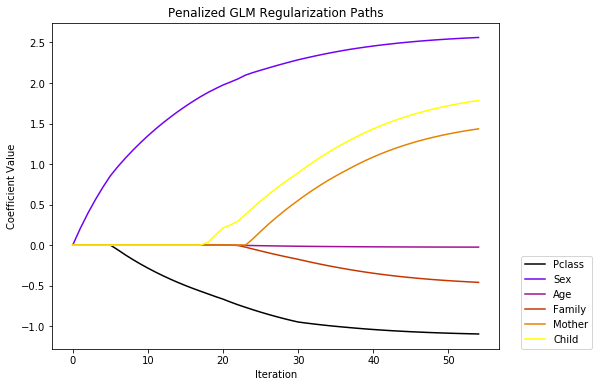

In [14]:
# collect regularization paths from dict in DataFrame
reg_path_dict = best_glm.getGLMRegularizationPath(best_glm)
reg_path_frame = pd.DataFrame(columns=reg_path_dict['coefficients'][0].keys())
for i in range(0, len(reg_path_dict['coefficients'])): 
    reg_path_frame = reg_path_frame.append(reg_path_dict['coefficients'][i], 
                                           ignore_index=True)

    
# establish benchmark feature selection: glm_selected 
glm_selected = list(reg_path_frame.iloc[-1, :][abs(reg_path_frame.iloc[-1, :]) > GLM_SELECTION_THRESHOLD].index) #debug point: Need make the THRESHOLD being absolute value since we have negative correlation

glm_selected_new = glm_selected[0:6] #drop the intercept

# plot regularization paths
fig, ax_ = plt.subplots(figsize=(8, 6))
_ = reg_path_frame[glm_selected_new].plot(kind='line', ax=ax_, title='Penalized GLM Regularization Paths',
                                      colormap='gnuplot')
_ = ax_.set_xlabel('Iteration')
_ = ax_.set_ylabel('Coefficient Value')
#_ = ax_.axhline(c='k', lw=1, xmin=0.045, xmax=0.955)
_ = plt.legend(bbox_to_anchor=(1.05, 0),
               loc=3, 
               borderaxespad=0.)

### 3.5 Compare Global Model Weights Against Alternative Model

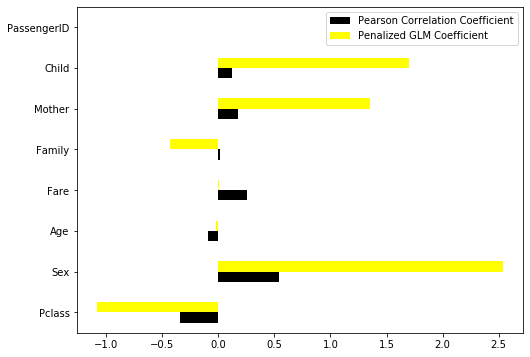

In [15]:
# collect Pearson correlation and GLM coefficients into same DataFrame
glm_selected_coef = pd.DataFrame.from_dict(best_glm.coef(), orient='index', columns=['Penalized GLM Coefficient'])
corr_glm = pd.concat([corr, glm_selected_coef.iloc[1:]], axis=1)

# plot
fig, ax_ = plt.subplots(figsize=(8, 6))
_ = corr_glm.plot(kind='barh', ax=ax_, colormap='gnuplot')

As compared to Pearson correlation, the penalized GLM only selected 6 features, `Pclass`,`Family`,`Age`,`Mother`,`Child`,`Sex`, that are either positively or negatively correlated to `Survived`. The `Fare` is dropped since the penalized GLM coefficient is smaller than our pre-set threshold. The most correlated feature, by model penalized GLM, is the `Sex` and the second strong positively correlated feature is `Child`. However, we can see there are two features negatively correlated with `Survived`, which are `Family` and `Age`. This point could be interesting for furthur analysis in the next.

### 3.6 Partial Dependence and ICE for Model Documentation to validate and explain monotonic behavior

Overlaying **partial dependence** onto **ICE** in a plot is a convenient way to validate and understand both global and local monotonic behavior. Plots of partial dependence curves explains the average behavior of the model based on the whole dataset; Plots of ICE explains that how an individual row in a specific variable would act if something change in the model, it is very similar to partial dependence, but focus more on local monotonic behavior rather than global one.

Partial dependence and ICE plots are displayed for the all selected variables in the penalized GLM.

#### 3.6.1 Calculate partial dependence for each feature in best GLM

In [16]:
# init dict to hold partial dependence and ICE values
# for each feature
# for glm
glm_pd_ice_dict = {}

# calculate partial dependence for each selected feature
for xs in glm_selected_new: 
    glm_pd_ice_dict[xs] = explain.pd_ice(xs, valid, best_glm)

#### 3.6.2 Find some percentiles of yhat in the validation data


Since we do not have interest on a particular individual, individuals at deciles (0, 10, 20, 30, 40, 50, 60, 70, 80, 90 and 99 percentiles) are selected for ICE under the penalized GLM.  

In [17]:
# merge GLM predictions onto test data
glm_yhat_valid = pd.concat([valid.reset_index(drop=True),
                            best_glm.predict(h2o.H2OFrame(valid))['p1'].as_data_frame()],
                           axis=1)

# rename yhat column
glm_yhat_valid = glm_yhat_valid.rename(columns={'p1':'p_Survived'})

# find percentiles of predictions
glm_percentile_dict = explain.get_percentile_dict('Survived', glm_yhat_valid, 'PassengerID')

# display percentiles dictionary
# key=percentile, val=row_id
glm_percentile_dict

{0: 1,
 99: 444,
 10: 333,
 20: 788,
 30: 679,
 40: 43,
 50: 168,
 60: 18,
 70: 80,
 80: 418,
 90: 645}

#### 3.6.3 Calculate ICE curve values for each features in deciles.

In [18]:
# loop through selected features
for xs in glm_selected_new: 

    # collect bins used in partial dependence
    bins = list(glm_pd_ice_dict[xs][xs])
    
    # calculate ICE at percentiles 
    # using partial dependence bins
    # for each selected feature
    for i in sorted(glm_percentile_dict.keys()):
        col_name = 'Percentile_' + str(i)
        glm_pd_ice_dict[xs][col_name] = explain.pd_ice(xs, # x_names used here b/c all features have small coef in GLM
                                                       valid[valid['PassengerID'] == int(glm_percentile_dict[i])][x_names], 
                                                       best_glm, 
                                                       bins=bins)['partial_dependence']
       

#### 3.6.4 Assess partial dependence and ICE for each feature in best GLM

In [19]:
#### Function to plot partial dependence and ICE

def plot_par_dep_ICE(xs, par_dep_frame):

    
    """ Plots ICE overlayed onto partial dependence for a single variable.
    
    Args: 
        xs: Name of variable for which to plot ICE and partial dependence.
        par_dep_frame: Name of Pandas DataFrame containing ICE and partial
                       dependence values.
    
    """
    
    # initialize figure and axis
    fig, ax = plt.subplots()
    
    # plot ICE curves
    par_dep_frame.drop('partial_dependence', axis=1).plot(x=xs, 
                                                          colormap='gnuplot',
                                                          ax=ax)

    # overlay partial dependence, annotate plot
    par_dep_frame.plot(title='Partial Dependence and ICE for ' + str(xs),
                       x=xs, 
                       y='partial_dependence',
                       style='r-', 
                       linewidth=3, 
                       ax=ax)

    # add legend
    _ = plt.legend(bbox_to_anchor=(1.05, 0),
                   loc=3, 
                   borderaxespad=0.)


#### Partial Dependence and ICE plot for `Pclass`

In [20]:
par_dep_glm_Pclass = glm_pd_ice_dict['Pclass']

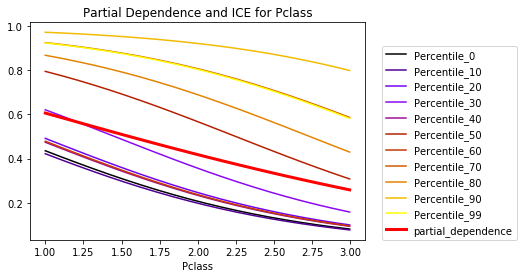

In [21]:
plot_par_dep_ICE('Pclass',par_dep_glm_Pclass)

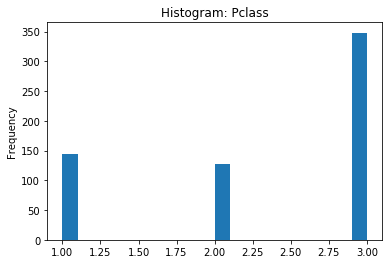

In [22]:
_ = train['Pclass'].plot(kind='hist', bins = 20, title='Histogram: Pclass')

#### Partial Dependence and ICE plot for `Sex`

In [23]:
par_dep_glm_Sex = glm_pd_ice_dict['Sex']

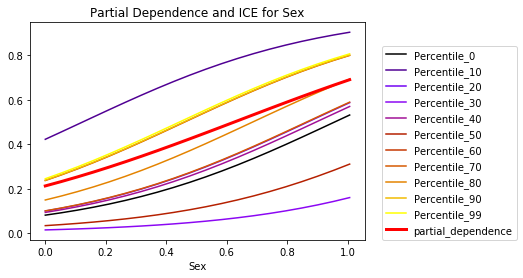

In [24]:
plot_par_dep_ICE('Sex',par_dep_glm_Sex)

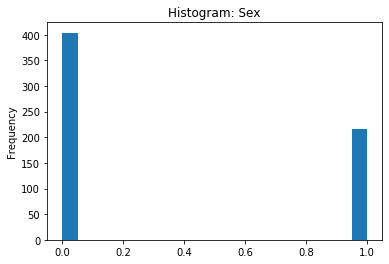

In [25]:
_ = train['Sex'].plot(kind='hist', bins = 20, title='Histogram: Sex')

#### Partial Dependence and ICE plot for `Age`

In [26]:
par_dep_glm_Age = glm_pd_ice_dict['Age']

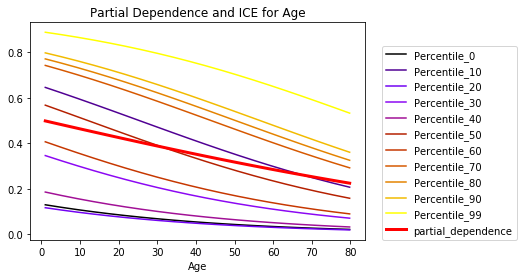

In [27]:
plot_par_dep_ICE('Age',par_dep_glm_Age)

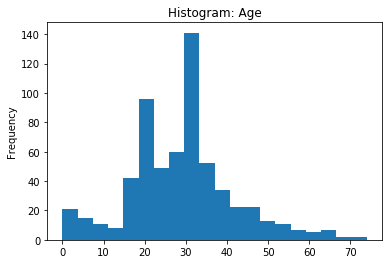

In [28]:
_ = train['Age'].plot(kind='hist', bins = 20, title='Histogram: Age')

#### Partial Dependence and ICE plot for `Family`

In [29]:
par_dep_glm_Family = glm_pd_ice_dict['Family']

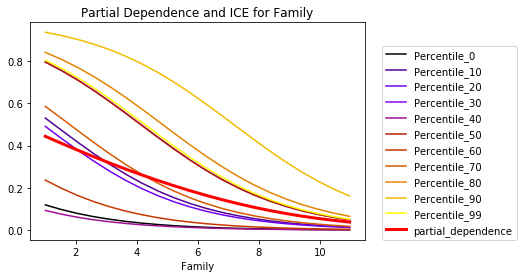

In [30]:
plot_par_dep_ICE('Family',par_dep_glm_Family)

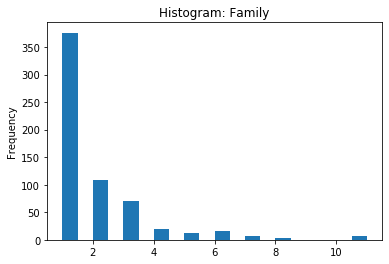

In [31]:
_ = train['Family'].plot(kind='hist', bins = 20, title='Histogram: Family')

#### Partial Dependence and ICE plot for `Mother`

In [32]:
par_dep_glm_Mother = glm_pd_ice_dict['Mother']

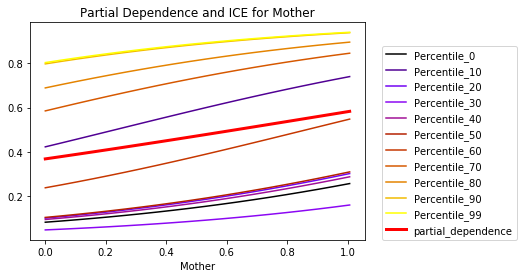

In [33]:
plot_par_dep_ICE('Mother',par_dep_glm_Mother)

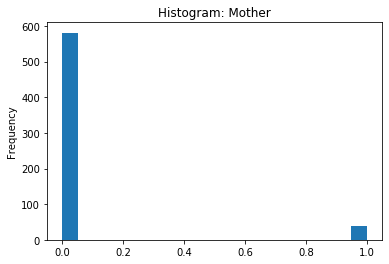

In [34]:
_ = train['Mother'].plot(kind='hist', bins = 20, title='Histogram: Mother')

#### Partial Dependence and ICE plot for `Child`

In [35]:
par_dep_glm_Child = glm_pd_ice_dict['Child']

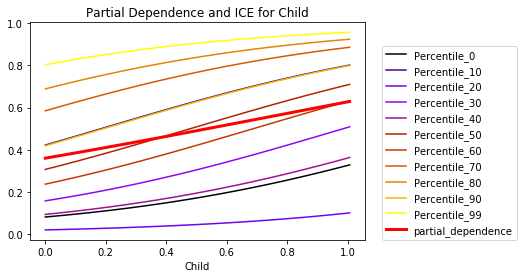

In [36]:
plot_par_dep_ICE('Child',par_dep_glm_Child)

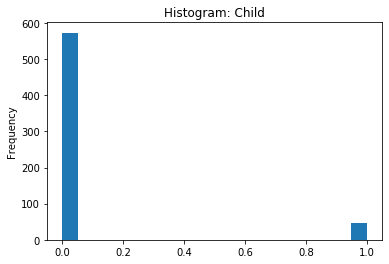

In [37]:
_ = train['Child'].plot(kind='hist', bins = 20, title='Histogram: Child')

From above plots of histogram and of partial dependence and ICE on all features, we can see only the `Age` and `Family` data are distributed trustworthy because there is little or no training data for these dummy variables. We can also find that since all of our feature has absolute correlation value under 0.5, the prediction of model is not dramatically changed by the different value of features.

From the partial and dependence with ICE only, we see all features average behaviors have the same pattern as individual behaviors, which indicate there is no local interaction exist in our penalized model.

The only two interpretable features in these plots are `Age` and `Family`. 

For `Age`, most passengers on this ship are concentrated from 20 to 50 years old, but younger passengers have more higher possibility to be survived. 

For `Family`, with less family members on board could increase her/his possibility to be survived. 

All these explanations can be applied to all individuals, since there is only global feature importance exist. (If the partial dependence diverges from ICE, we can tell there should be local interaction/information exists in this feature somewhere.) 

# 4. Make prediction based on best GLM model for Kaggle Compete

### 4.1 Generate the Elastic Net GLM prediction without percent known result (totally blind)

In [38]:
pred_glm = best_glm.predict(h2o.H2OFrame(test))

### 4.2 Prediction dataset manipulation to have final dataframe matching the requirements of Kaggle Compete

We decided to change the threshold of `Survived` prediction because the original threshold was 0.4, which means if the model predict 0.40001 percent of possibility on a passenger to be saved, the final prediction will recoginze this passenger to be survived (survived = 1). We have changed the threshold from **0.4** to **0.5**, which means the possibilities of being not survived and of being survived are equal, and we find this change has improved our accuracy on Kaggle compete by nearly **2%**. Later, we may keep tuning the model and testing the threshold until we find the highest accuracy eventually.

In [39]:
pred_glm_list = h2o.as_list(pred_glm, use_pandas=False)

pred_glm_pandas = pd.DataFrame(pred_glm_list[1:], columns = pred_glm_list[0])

for i in range(0,test.shape[0]):
    if float(pred_glm_pandas["p0"][i]) > 0.5:
        pred_glm_pandas["predict"][i] = 0
    elif float(pred_glm_pandas["p0"][i]) <= 0.5:
        pred_glm_pandas["predict"][i] = 1

glm_submission = pd.DataFrame({'PassengerID': test['PassengerID'],'Survived':pred_glm_pandas['predict']})

glm_submission

,PassengerID,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


#### Output the submission dataframe as csv.

In [40]:
glm_submission.to_csv('submission_EN_GLM.csv',index = False)

# ----------------------------------------------------------------------------------------------------------------

## Monotonic GBM (MGBM)

# 5. Train Monotonic GBM with Selected 6 Feature Selection: 
### `Pclass`,`Sex`,`Class`,`Family`,`Mother`,`Child`.

### 5.1 Forward Step-wise Training

Our monotonic GBM starts with 6 selected features by the penalized GLM, then we will keep adding one additional feature in the next most correlated feature from original train dataset to the model.

Each new set after adding one additional feature will run through a random grid search to make sure a stable and accurate GBM is trained by Forward Step-wise training steps.

In [41]:
# initialize data structures needed to compare correlation coefficients,
# penalized glm coefficients, and MGBM Shapley values
# as features are added into the MGBM
abs_corr = corr.copy(deep=True)
abs_corr['Pearson Correlation Coefficient'] = corr['Pearson Correlation Coefficient'].abs()

# create a list of features to add into MGBM
# list is ordered by correlation between X_j and y
next_list = [name for name in list(abs_corr.sort_values(by='Pearson Correlation Coefficient',
                                                        ascending=False).index) if name not in glm_selected_new]

# create a DataFrame to store new MGBM SHAP values
# for comparison to correlation and penalized glm coefficients
abs_corr_glm_mgbm_shap = corr_glm.copy(deep=True).abs()
abs_corr_glm_mgbm_shap.columns = ['Absolute ' + name for name in abs_corr_glm_mgbm_shap.columns]
abs_corr_glm_mgbm_shap['Monotonic GBM Mean SHAP Value'] = 0

# start local timer
tic = time.time()

# forward stepwise MGBM training
mgbm_train_results = model.gbm_forward_select_train(glm_selected_new, 
                                                    y_name, 
                                                    train, 
                                                    valid, 
                                                    SEED, 
                                                    next_list,
                                                    abs_corr_glm_mgbm_shap, 
                                                    'Monotonic GBM Mean SHAP Value',
                                                    monotone=True)

mgbm_models = mgbm_train_results['MODELS']
corr_glm_mgbm_shap_coefs = mgbm_train_results['GLOBAL_COEFS']
mgbm_shap = mgbm_train_results['LOCAL_COEFS']

# end local timer
toc = time.time()-tic
print('Task completed in %.2f s.' % (toc))


Starting grid search 1/3 ...
Input features = ['Pclass', 'Sex', 'Age', 'Family', 'Mother', 'Child']
Monotone constraints = {'Pclass': -1, 'Sex': 1, 'Age': -1, 'Family': 1, 'Mother': 1, 'Child': 1}
Completed grid search 1/3 with AUC: 0.85 ...
--------------------------------------------------------------------------------
Starting grid search 2/3 ...
Input features = ['Pclass', 'Sex', 'Age', 'Family', 'Mother', 'Child', 'Fare']
Monotone constraints = {'Pclass': -1, 'Sex': 1, 'Age': -1, 'Family': 1, 'Mother': 1, 'Child': 1, 'Fare': 1}
Completed grid search 2/3 with AUC: 0.85 ...
--------------------------------------------------------------------------------
Starting grid search 3/3 ...
Input features = ['Pclass', 'Sex', 'Age', 'Family', 'Mother', 'Child', 'Fare', 'PassengerID']
Monotone constraints = {'Pclass': -1, 'Sex': 1, 'Age': -1, 'Family': 1, 'Mother': 1, 'Child': 1, 'Fare': 1, 'PassengerID': 1}
Completed grid search 3/3 with AUC: 0.85 ...
-----------------------------------------

### 5.2 Compare Global Model Weights for Alternative Models

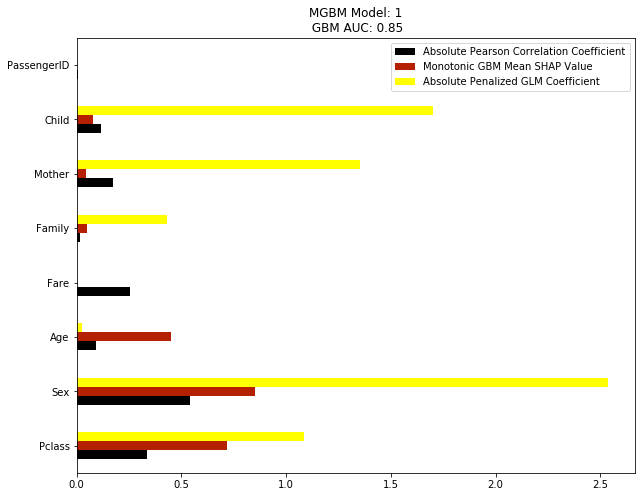

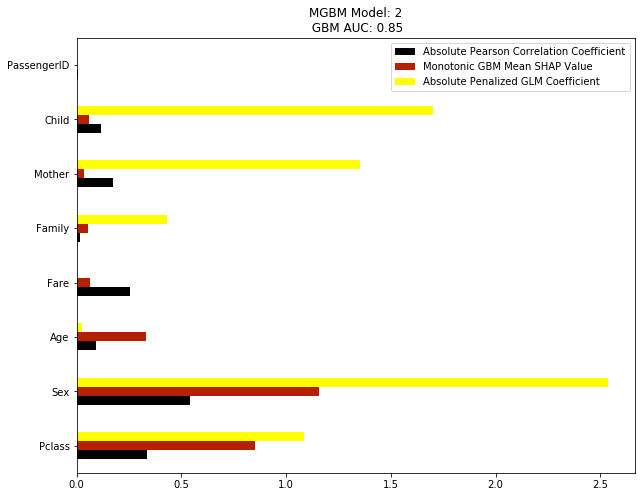

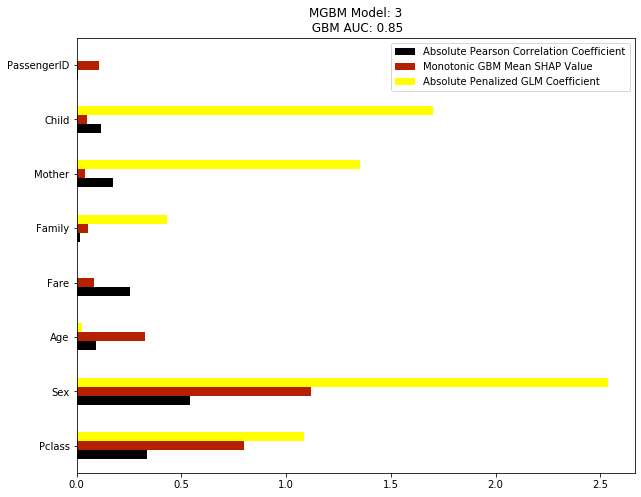

In [42]:
explain.plot_coefs(corr_glm_mgbm_shap_coefs,
                   mgbm_models, 
                   'MGBM',
                   ['Absolute Pearson Correlation Coefficient',
                    'Monotonic GBM Mean SHAP Value',
                    'Absolute Penalized GLM Coefficient'])

### 5.3 Perform Cross-validated Ranking to Select Best MGBM Against Alternative Models

Because our data is extramely small, it does not make sense to select a best GBM model based on one value in a validation set. Hence, evaluate(), a combination of ranking models across many metrics and many folds is used to sort out the best GBM model.

In [43]:
# autoph cv_model_rank_select function
# requires models to have model_id 
best_glm.model_id = 'best_glm'
compare_model_ids = ['best_glm'] # list of model_ids

# start local timer
tic = time.time()

# perform CV rank model selection
mgbm_rank_results = evaluate.cv_model_rank_select(valid,
                                                  SEED,
                                                  mgbm_train_results,
                                                  'mgbm',
                                                  compare_model_ids)

best_mgbm = mgbm_rank_results['BEST_MODEL']
best_mgbm_shap = mgbm_rank_results['BEST_LOCAL_COEFS']
mgbm_selected_coefs = mgbm_rank_results['BEST_GLOBAL_COEFS']
best_mgbm_eval = mgbm_rank_results['METRICS']


# end local timer
toc = time.time()-tic
print('Task completed in %.2f s.' % (toc))

Evaluated model 1/3 with rank: 1.46* ...
Evaluated model 2/3 with rank: 1.50 ...
Evaluated model 3/3 with rank: 1.52 ...
Done.
Task completed in 7.19 s.


### 5.4 Model Details for Model Documentation

#### Inspect best MGBM

In [44]:
best_mgbm

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  mgbm1


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,52.0,52.0,6057.0,1.0,3.0,2.692308,2.0,7.0,4.615385




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.1274986955326404
RMSE: 0.3570695948028065
LogLoss: 0.4067923325491864
Mean Per-Class Error: 0.197603121516165
AUC: 0.8690691192865106
AUCPR: 0.8148415328965769
Gini: 0.7381382385730213

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3566863250417771: 


,,0,1,Error,Rate
0,0,302.0,88.0,0.2256,(88.0/390.0)
1,1,39.0,191.0,0.1696,(39.0/230.0)
2,Total,341.0,279.0,0.2048,(127.0/620.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.356686,0.750491,99.0
1,max f2,0.220454,0.809061,119.0
2,max f0point5,0.579777,0.824937,68.0
3,max accuracy,0.579777,0.824194,68.0
4,max precision,0.854474,0.979167,53.0
5,max recall,0.036236,1.000000,167.0
6,max specificity,0.969393,0.997436,0.0
7,max absolute_mcc,0.579777,0.626841,68.0
8,max min_per_class_accuracy,0.385111,0.778261,96.0
9,max mean_per_class_accuracy,0.356686,0.802397,99.0



Gains/Lift Table: Avg response rate: 37.10 %, avg score: 36.85 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.016129,0.950817,2.156522,2.156522,0.800000,0.953975,0.800000,0.953975,0.034783,0.034783,115.652174,115.652174
1,,2,0.022581,0.946761,2.695652,2.310559,1.000000,0.947463,0.857143,0.952114,0.017391,0.052174,169.565217,131.055901
2,,3,0.030645,0.941738,2.695652,2.411899,1.000000,0.944725,0.894737,0.950170,0.021739,0.073913,169.565217,141.189931
3,,4,0.043548,0.936481,2.695652,2.495974,1.000000,0.938904,0.925926,0.946832,0.034783,0.108696,169.565217,149.597424
4,,5,0.050000,0.932399,2.695652,2.521739,1.000000,0.934876,0.935484,0.945289,0.017391,0.126087,169.565217,152.173913
5,,6,0.101613,0.911907,2.695652,2.610076,1.000000,0.920591,0.968254,0.932744,0.139130,0.265217,169.565217,161.007591
6,,7,0.150000,0.858376,2.695652,2.637681,1.000000,0.887827,0.978495,0.918255,0.130435,0.395652,169.565217,163.768116
7,,8,0.204839,0.651678,2.140665,2.504622,0.794118,0.788496,0.929134,0.883516,0.117391,0.513043,114.066496,150.462170
8,,9,0.320968,0.482787,1.385266,2.099629,0.513889,0.509910,0.778894,0.748342,0.160870,0.673913,38.526570,109.962858
9,,10,0.400000,0.391266,1.210293,1.923913,0.448980,0.437278,0.713710,0.686882,0.095652,0.769565,21.029281,92.391304




ModelMetricsBinomial: gbm
** Reported on validation data. **

MSE: 0.14501361618291111
RMSE: 0.3808065337975586
LogLoss: 0.4582546105570124
Mean Per-Class Error: 0.19884321653189574
AUC: 0.8537735849056604
AUCPR: 0.8422927919579934
Gini: 0.7075471698113207

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3436790637753099: 


,,0,1,Error,Rate
0,0,127.0,32.0,0.2013,(32.0/159.0)
1,1,22.0,90.0,0.1964,(22.0/112.0)
2,Total,149.0,122.0,0.1993,(54.0/271.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.343679,0.769231,61.0
1,max f2,0.194999,0.807249,82.0
2,max f0point5,0.648438,0.795455,37.0
3,max accuracy,0.426974,0.811808,51.0
4,max precision,0.952801,1.000000,0.0
5,max recall,0.036236,1.000000,113.0
6,max specificity,0.952801,1.000000,0.0
7,max absolute_mcc,0.426974,0.608259,51.0
8,max min_per_class_accuracy,0.343679,0.798742,61.0
9,max mean_per_class_accuracy,0.343679,0.801157,61.0



Gains/Lift Table: Avg response rate: 41.33 %, avg score: 37.43 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.011070,0.948464,2.419643,2.419643,1.000000,0.951478,1.000000,0.951478,0.026786,0.026786,141.964286,141.964286
1,,2,0.022140,0.943785,2.419643,2.419643,1.000000,0.946393,1.000000,0.948935,0.026786,0.053571,141.964286,141.964286
2,,3,0.033210,0.938139,2.419643,2.419643,1.000000,0.939945,1.000000,0.945939,0.026786,0.080357,141.964286,141.964286
3,,4,0.044280,0.928411,2.419643,2.419643,1.000000,0.929056,1.000000,0.941718,0.026786,0.107143,141.964286,141.964286
4,,5,0.059041,0.927491,2.419643,2.419643,1.000000,0.927491,1.000000,0.938161,0.035714,0.142857,141.964286,141.964286
5,,6,0.103321,0.893533,2.218006,2.333227,0.916667,0.906117,0.964286,0.924428,0.098214,0.241071,121.800595,133.322704
6,,7,0.154982,0.853929,2.246811,2.304422,0.928571,0.875635,0.952381,0.908163,0.116071,0.357143,124.681122,130.442177
7,,8,0.217712,0.651678,2.134979,2.255599,0.882353,0.744869,0.932203,0.861112,0.133929,0.491071,113.497899,125.559927
8,,9,0.321033,0.482787,1.469069,2.002463,0.607143,0.524253,0.827586,0.752698,0.151786,0.642857,46.906888,100.246305
9,,10,0.420664,0.370826,1.254630,1.825345,0.518519,0.411194,0.754386,0.671815,0.125000,0.767857,25.462963,82.534461




Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2020-06-26 22:26:08,1.515 sec,0.0,0.483064,0.659469,0.500000,0.370968,1.000000,0.629032,0.494238,0.681815,0.500000,0.413284,1.000000,0.586716
1,,2020-06-26 22:26:08,1.515 sec,1.0,0.467498,0.628303,0.779437,0.758427,2.613966,0.198387,0.479934,0.652487,0.761540,0.750252,2.333227,0.380074
2,,2020-06-26 22:26:08,1.515 sec,2.0,0.451752,0.597733,0.851310,0.810447,2.567288,0.195161,0.464149,0.621127,0.854672,0.842448,2.419643,0.184502
3,,2020-06-26 22:26:08,1.515 sec,3.0,0.439711,0.575389,0.858278,0.815703,2.567288,0.232258,0.454387,0.602745,0.852454,0.840380,2.419643,0.239852
4,,2020-06-26 22:26:08,1.515 sec,4.0,0.427244,0.552357,0.855452,0.811547,2.567288,0.233871,0.443018,0.581268,0.853858,0.841422,2.419643,0.225092
5,,2020-06-26 22:26:08,1.515 sec,5.0,0.416388,0.532272,0.860602,0.814110,2.426087,0.211290,0.433412,0.563087,0.856581,0.846822,2.419643,0.177122
6,,2020-06-26 22:26:08,1.530 sec,6.0,0.407781,0.516341,0.857926,0.810027,2.426087,0.204839,0.425477,0.548014,0.851892,0.841245,2.419643,0.195572
7,,2020-06-26 22:26:08,1.530 sec,7.0,0.400501,0.502555,0.858534,0.807985,2.426087,0.220968,0.418705,0.534905,0.854139,0.843556,2.419643,0.210332
8,,2020-06-26 22:26:08,1.530 sec,8.0,0.397840,0.497100,0.861851,0.808542,2.471014,0.219355,0.417737,0.532492,0.851555,0.828225,2.419643,0.188192
9,,2020-06-26 22:26:08,1.530 sec,9.0,0.392750,0.487015,0.859554,0.800994,2.280936,0.222581,0.413971,0.525073,0.852679,0.832040,2.419643,0.202952



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,Sex,168.740128,1.000000,0.620449
1,Pclass,65.341301,0.387230,0.240257
2,Age,27.508318,0.163022,0.101147
3,Child,5.543675,0.032853,0.020384
4,Mother,3.865798,0.022910,0.014214
5,Family,0.965245,0.005720,0.003549


#### Assess best MGBM Ranking

In [45]:
best_mgbm_eval

,Fold,Metric,best_glm Value,mgbm1 Value,best_glm Rank,mgbm1 Rank
0,0,F1,0.800000,0.869565,2.0,1.0
1,0,accuracy,0.870968,0.903226,2.0,1.0
2,0,auc,0.899666,0.909142,2.0,1.0
3,0,logloss,0.371824,0.362589,2.0,1.0
4,0,mcc,0.735640,0.793163,2.0,1.0
5,1,F1,0.765957,0.754717,1.0,2.0
6,1,accuracy,0.807018,0.771930,1.0,2.0
7,1,auc,0.835000,0.791875,1.0,2.0
8,1,logloss,0.497590,0.535477,1.0,2.0
9,1,mcc,0.606480,0.545921,1.0,2.0


In [46]:
print('Best GLM mean rank:', best_mgbm_eval['best_glm Rank'].mean())
print('Best MGBM mean rank:', best_mgbm_eval['mgbm1 Rank'].mean())

Best GLM mean rank: 1.54
Best MGBM mean rank: 1.46


### 5.5 Main Drivers of Model Decisions: Global Shapley Feature Importance

#### 5.5.1 Calculate Shapley values for the MGBM predictions
In `h2o`, for GBM and random forest models, the `predict_contributions` function is used to calculate Shapley values. Notice the Shapley values are the same size as the input feature matrix, plus one constant column for the Shapley intercept.

In [47]:
shap_contribs_hf = best_mgbm.predict_contributions(h2o.H2OFrame(valid))
shap_contribs_matrix = shap_contribs_hf.as_data_frame().values
print(shap_contribs_matrix)
print('\nShapley contributions rows = %d, columns = %d' % (shap_contribs_matrix.shape[0], shap_contribs_matrix.shape[1]))

[[-0.46006674 -0.54075003 -0.15084057 ... -0.03121466 -0.09794173
  -0.51814997]
 [ 1.12944436 -0.7010743  -1.12354648 ... -0.02064864 -0.08446261
  -0.51814997]
 [-0.55645984  1.01127124 -0.04096343 ...  0.36882654 -0.03758435
  -0.51814997]
 ...
 [ 1.47450793  1.54776895  0.28797135 ... -0.0087557  -0.03314219
  -0.51814997]
 [ 0.91144192 -0.62435144 -0.07947954 ... -0.01500704 -0.07606307
  -0.51814997]
 [-0.45738739 -0.54660922 -0.23414744 ... -0.03121466 -0.10653345
  -0.51814997]]

Shapley contributions rows = 271, columns = 7


#### 5.5.2 Plot global Shapley feature importance
Global Shapley feature importance is calculated as the average absolute Shapley value for all input features based on the prediction of model with validation dataset. The values in the chart below can be interpreted as the mean absolute contribution a feature makes on a model prediction.

In [48]:
x_names_new = ['Pclass', 'Sex', 'Age', 'Family', 'Mother', 'Child'] #Selected features of best_mgbm

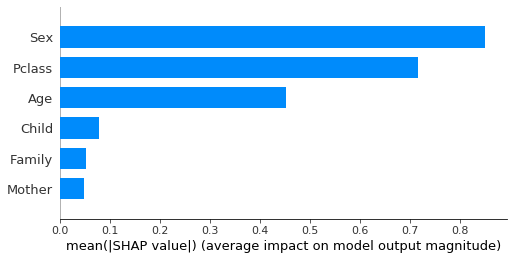

In [49]:
shap_contribs = shap_contribs_matrix[:,:-1] # remove constant intercept column
shap.summary_plot(shap_contribs, x_names_new, plot_type='bar') # use shap package for nice bar plot

In the plot of global Shapley feature importance, we can find a familiar pattern that we have seen from the Pearson correlation: features `Sex` and `Pclass` contributed the most part of the global feature importance. However, we know that both penalized GLM and monotonic GBM have selected 6 features as the best model in terms of accuracy, but we have only see 5 features (and Fare is not the selected one!) contributed to the model prediction in this Shapley plot, and this could be problemtic! 

If these two variables are recorded incorrectly, or being drifted purposly by bad intentions, the model could be trained incorrectly, and the prediction could be totally messed up. 

### 5.6 Partial Dependence and ICE for Model Documentation

#### 5.6.1 Calculate Partial Dependence for each feature in best MGBM

In [50]:
# init dict to hold partial dependence and ICE values
# for each feature
# for mgbm
mgbm_pd_ice_dict = {}

# establish mgbm selected features
mgbm_selected = list(mgbm_selected_coefs[mgbm_selected_coefs['Monotonic GBM Mean SHAP Value'] != 0].index)

# calculate partial dependence for each selected feature
for xs in mgbm_selected: 
    mgbm_pd_ice_dict[xs] = explain.pd_ice(xs, valid, best_mgbm)

#### 5.6.2 Find some percentiles of yhat in the validation data

In [51]:
# merge MGBM predictions onto test data
mgbm_yhat_valid = pd.concat([valid.reset_index(drop=True),
                             best_mgbm.predict(h2o.H2OFrame(valid))['p1'].as_data_frame()],
                            axis=1)

# rename yhat column
mgbm_yhat_valid = mgbm_yhat_valid.rename(columns={'p1':'p_Survived'})

# find percentiles of predictions
mgbm_percentile_dict = explain.get_percentile_dict('p_Survived', mgbm_yhat_valid, 'PassengerID')

# display percentiles dictionary
# key=percentile, val=row_id
mgbm_percentile_dict

{0: 281,
 99: 586,
 10: 96,
 20: 839,
 30: 554,
 40: 865,
 50: 660,
 60: 840,
 70: 728,
 80: 449,
 90: 547}

#### 5.6.3 Calculate ICE curve values

In [52]:
# loop through selected features
for xs in mgbm_selected: 

    # collect bins used in partial dependence
    bins = list(mgbm_pd_ice_dict[xs][xs])
    
    # calculate ICE at percentiles 
    # using partial dependence bins
    # for each selected feature
    for i in sorted(mgbm_percentile_dict.keys()):
        col_name = 'Percentile_' + str(i)
        mgbm_pd_ice_dict[xs][col_name] = explain.pd_ice(xs, 
                                                        valid[valid['PassengerID'] == int(mgbm_percentile_dict[i])][mgbm_selected], 
                                                        best_mgbm, 
                                                        bins=bins)['partial_dependence']
       

#### 5.6.4 Assess PD and ICE for each feature in best MGBM

The difference of partial dependence with ICE plot between penalized GLM and monotonic GBM is that the plots are jumping/dropping discretely instead of jumping/dropping linearly, and this time, we can explain all other features who are dummy variabls by this discrete partial dependence with ICE plot. 

For an instance,monotonically constrainted prediction on `Pclass` drops the survived possibility each time from 0.6 to 0.42 to 0.25 when the passenger's class changed from 1st to 2nd to 3rd with remain other variable constant, and this follows our common sense obtained from the film Titanic, that the amount of survived high-class passenger is much more than the amount of lower class passenger. This is a typical explanation of a variable changes by interpretable models, and we could have more question being answered in such way. 

#### Partial Dependence and ICE plot for `Pclass`

In [53]:
par_dep_mgbm_Pclass = mgbm_pd_ice_dict['Pclass']

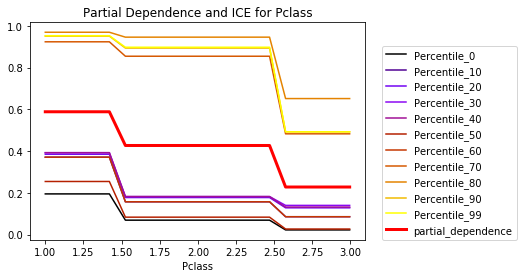

In [54]:
plot_par_dep_ICE('Pclass',par_dep_mgbm_Pclass)

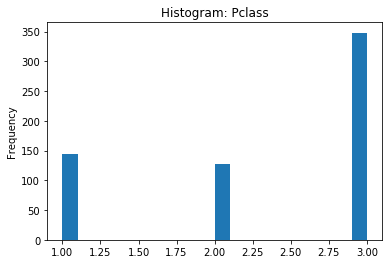

In [55]:
_ = train['Pclass'].plot(kind='hist', bins = 20, title='Histogram: Pclass')

#### Partial Dependence and ICE plot for `Sex`

In [56]:
par_dep_mgbm_Sex = mgbm_pd_ice_dict['Sex']

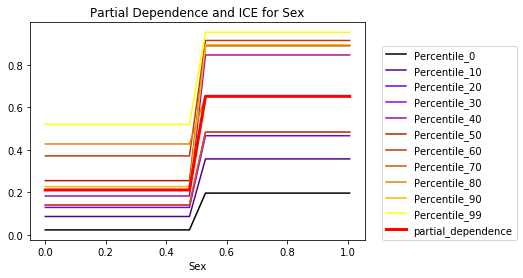

In [57]:
plot_par_dep_ICE('Sex',par_dep_mgbm_Sex)

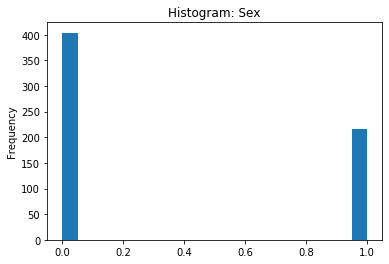

In [58]:
_ = train['Sex'].plot(kind='hist', bins = 20, title='Histogram: Sex')

#### Partial Dependence and ICE plot for `Age`

In [59]:
par_dep_mgbm_Age = mgbm_pd_ice_dict['Age']

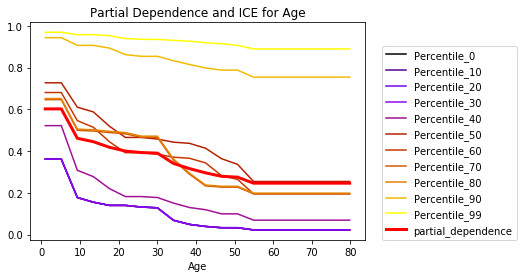

In [60]:
plot_par_dep_ICE('Age',par_dep_mgbm_Age)

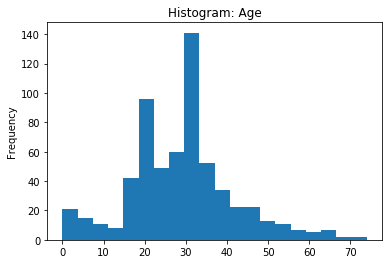

In [61]:
_ = train['Age'].plot(kind='hist', bins = 20, title='Histogram: Age')

#### Partial Dependence and ICE plot for `Family`

In [62]:
par_dep_mgbm_Family = mgbm_pd_ice_dict['Family']

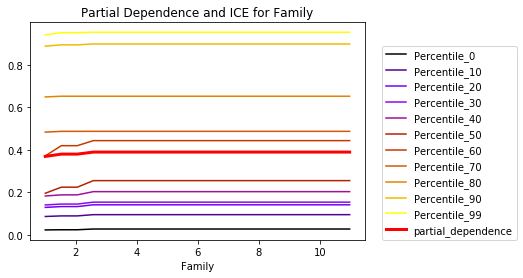

In [63]:
plot_par_dep_ICE('Family',par_dep_mgbm_Family)

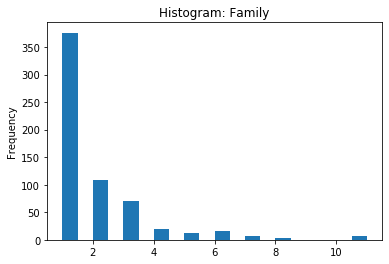

In [64]:
_ = train['Family'].plot(kind='hist', bins = 20, title='Histogram: Family')

#### Partial Dependence and ICE plot for `Mother`

In [65]:
par_dep_mgbm_Mother = mgbm_pd_ice_dict['Mother']

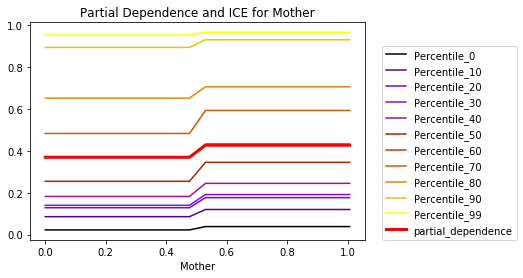

In [66]:
plot_par_dep_ICE('Mother',par_dep_mgbm_Mother)

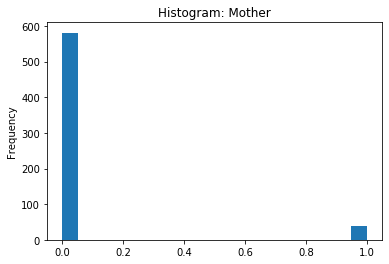

In [67]:
_ = train['Mother'].plot(kind='hist', bins = 20, title='Histogram: Mother')

#### Partial Dependence and ICE plot for `Child`

In [68]:
par_dep_mgbm_Child = mgbm_pd_ice_dict['Child']

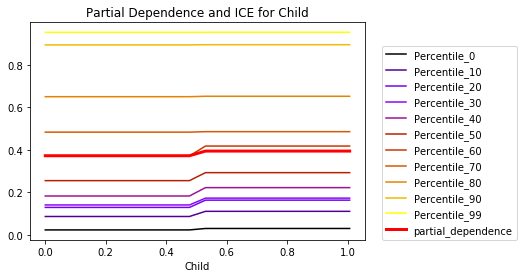

In [69]:
plot_par_dep_ICE('Child',par_dep_mgbm_Child)

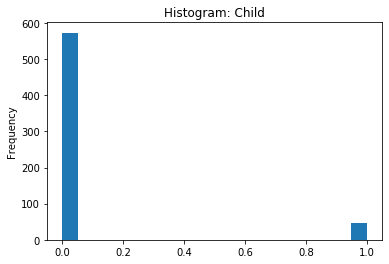

In [70]:
_ = train['Child'].plot(kind='hist', bins = 20, title='Histogram: Child')

### 5.7 Local Shapley Explanations on Passenger Level
With the exception of ICE, the methods in this notebook have been focused on global summaries of models, or summaries across entire partitions of data. Shapley values and a few other techniques, allow for the construction of highly localized summaries of the customer-level behavior of the model. 

#### 5.7.1 Create data structure for local coefficients
Shapley values at the 10th, 30th, 50th, 70th and 90th percentiles of `p_Survived` will be displayed to give some flavor of how `best_mgbm` treats different kinds of passenger.

In [71]:
local_coef_dict = {10: pd.DataFrame(columns = ['Shapley Contribution'], index=x_names_new),
                   30: pd.DataFrame(columns = ['Shapley Contribution'], index=x_names_new),
                   50: pd.DataFrame(columns = ['Shapley Contribution'], index=x_names_new),
                   70: pd.DataFrame(columns = ['Shapley Contribution'], index=x_names_new),
                   90: pd.DataFrame(columns = ['Shapley Contribution'], index=x_names_new)}

#### 5.7.2 Create mapping between validation set ID and Shapley value array indices

In [72]:
# validation data IDs are from credit card data
# Shapley contribs are indexed from 0, like any numpy array
valid_idx_map = valid['PassengerID'].copy(deep=True)
valid_idx_map.reset_index(drop=True, inplace=True) # Pandas index will now start from 0
valid_idx_map[0:5] # Shapley array index on left, ID on right

0     1
1     7
2     9
3    11
4    12
Name: PassengerID, dtype: int64

#### 5.7.3 Find local contributions for best MGBM at five percentiles of `p_Survived`
Using the mapping created above, Shapley values for three individuals are extracted from the numpy array of Shapley contributions and stored as DataFrames. 

In [73]:
# loop through features and percentiles
for name in x_names_new:
    for percentile in [10, 30, 50, 70, 90]:
    
        # use mapping find correct row of Shapley array
        # create a Pandas DataFrame from row of Shapley values
        idx = valid_idx_map[valid_idx_map == int(mgbm_percentile_dict[percentile])].index[0]
        s_df = pd.DataFrame(shap_contribs[idx, :].T, columns=['Shapley Contribution'], index=x_names_new)
        local_coef_dict[percentile]['Shapley Contribution'] = 0
        local_coef_dict[percentile].update(s_df)

#### 5.7.4 Plot Shapley contributions at five percentiles of `p_Survived`
Shapley values can be interpreted as the contribution that a feature makes to a single prediction, above or below the mean prediction of the model.

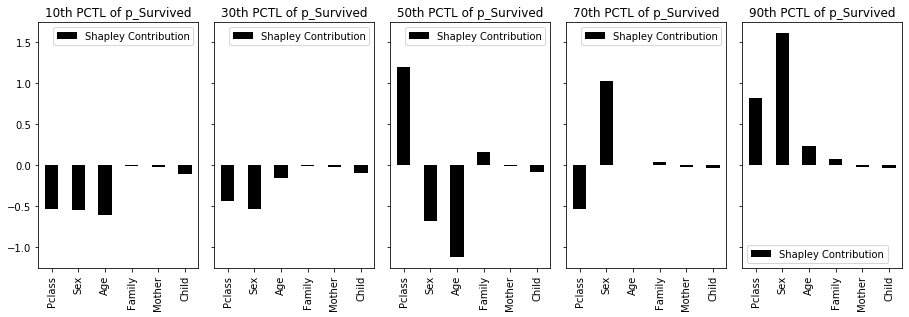

In [74]:
# initialize a three-pane plot
# with shared y-axis
fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(ncols=5, sharey=True)
plt.tight_layout()
plt.subplots_adjust(left=0, right=2, wspace=0.1)

# pane 1
_ = local_coef_dict[10].plot(kind='bar', color='k', ax=ax0,
                             title='10th PCTL of p_Survived')

# pane 2
_ = local_coef_dict[30].plot(kind='bar', color='k', ax=ax1,
                             title='30th PCTL of p_Survived')

# pane 3
_ = local_coef_dict[50].plot(kind='bar', color='k', ax=ax2,

                             title='50th PCTL of p_Survived')
# pane 4
_ = local_coef_dict[70].plot(kind='bar', color='k', ax=ax3,

                             title='70th PCTL of p_Survived')
# pane 5
_ = local_coef_dict[90].plot(kind='bar', color='k', ax=ax4,
                             title='90th PCTL of p_Survived')

Same but not same explanation from the global Shapley importance, features `Pclass` and `Sex` are still holding the helm of this ship. But it is different that per-passenger level, almost all features make negative contribution to the passenger with low probability of being survival, but once the probability increase, `Pclass` and `Sex` are alternatively play positive and negative contribution to the `p_Survived`. 

What gratifying is that `Sex` always play a positive contribution to people with higher probability of survival. In other words, "Women first" code was executed at that moment. 

About `Pclass`, the explanation could be more complex, since its contribution switched from positive to negative and back to positive with increasing possibility of survival, we may need to bring in expert on sociology and psychology or other fields to interpret such phenomenon. 

#### 5.7.5 Data values for individual at 90th percentile of `p_Survived`

In [75]:
mgbm_yhat_valid[mgbm_yhat_valid['PassengerID'] == mgbm_percentile_dict[90]]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Title,Family,Mother,Child,PassengerID,p_Survived
164,1,2,"Beane, Mrs. Edward (Ethel Clarke)",1,19,1,0,26.0,Mrs,2,0,0,547,0.893533


#### 5.7.6 Shapley values for individual at 90th percentile of `p_Survived`

In [76]:
local_coef_dict[90]

,Shapley Contribution
Pclass,0.814050
Sex,1.599657
Age,0.224139
Family,0.070610
Mother,-0.025215
Child,-0.037739


Pairing the data values for this passenger "Mrs. Beane Edward"with the Shapley values allows it to be seen that:

* This passenger is a woman, and she is not alone on this ship, but not a mother
* Her ticket class is 2nd which is the middle class of entire ship passenger group.
* She is 19 years old. 

are the main causes of high prediction for this passenger since `Pclass`, `Age` and `Sex` contribute the most of model prediction, and we can see these patterns from partial dependence with ICE plots that `Sex` has significant different p_Survived between **male** and **female**, `Pclass` has higher p_Survived when passenger's ticket class is better, and `Age` has higher p_Survived when the passenger is younger.

#### 5.7.7 Shapley values sum to model prediction in logit space
Shapley values plus the Shapley intercept (-0.51814997196) will add up to the model prediction for each row before the application of the logit link function. This is one of the most desirable properties of Shapley values.

In [77]:
local_coef_dict[90].sum()[0] + shap_contribs_matrix[0, -1]

2.127351935952902

In [78]:
print('Inverse logit of sum of Shapley contributions and intercept: %.6f' % expit(local_coef_dict[90].sum()[0] + shap_contribs_matrix[0, -1]))
print('MGBM prediction for individual: %6f' % mgbm_yhat_valid[mgbm_yhat_valid['PassengerID'] == mgbm_percentile_dict[90]]['p_Survived'])

Inverse logit of sum of Shapley contributions and intercept: 0.893533
MGBM prediction for individual: 0.893533


### 5.8 Make prediction based on best MGBM model

#### 5.8.1 Generate the Monotonic GBM prediction without percent known result (totally blind)

In [79]:
pred_mgbm = best_mgbm.predict(h2o.H2OFrame(test))

#### 5.8.2 Prediction dataset manipulation to have final dataframe matching the requirements of Kaggle Compete

In [80]:
pred_mgbm_list = h2o.as_list(pred_mgbm, use_pandas=False)

pred_mgbm_pandas = pd.DataFrame(pred_glm_list[1:], columns = pred_glm_list[0])

for i in range(0,418):
    if float(pred_mgbm_pandas["p0"][i]) > 0.5:
        pred_mgbm_pandas["predict"][i] = 0
    elif float(pred_mgbm_pandas["p0"][i]) <= 0.5:
        pred_mgbm_pandas["predict"][i] = 1

mgbm_submission = pd.DataFrame({'PassengerID': test['PassengerID'],'Survived':pred_mgbm_pandas['predict']})

mgbm_submission

,PassengerID,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


#### Output the submission dataframe as csv.

In [81]:
mgbm_submission.to_csv('submission_mgbm.csv',index = False)

# 6. Discrimination

### 6.1 Select a Probability Cutoff by Maximizing Youden's J Statistic

#### 6.1.1 Bind model predictions to test data for further calculations

In [82]:
valid = h2o.H2OFrame(valid)

In [83]:
yhat_name = 'p_Survived'
preds1 = valid['PassengerID'].cbind(best_mgbm.predict(valid).drop(['predict', 'p0']))
preds1.columns = ['ID', yhat_name]
valid_yhat = valid.cbind(preds1[yhat_name]).as_data_frame()
valid_yhat.reset_index(drop=True, inplace=True)

#### 6.1.2 Select best cutoff based on Youden's J

In [84]:
j_frame = evaluate.get_youdens_j(valid_yhat, y_name, yhat_name)
best_cut = j_frame.loc[j_frame['J'].idxmax(), 'cutoff'] 
print('%.2f' % best_cut)

0.34


#### 6.1.3 Plot ROC Curve

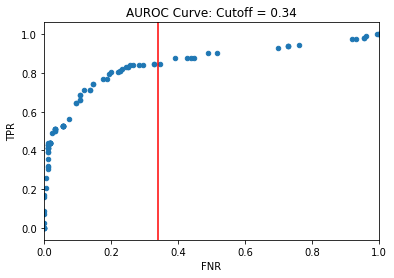

In [85]:
title_ = 'AUROC Curve: Cutoff = ' + str(best_cut)
ax = j_frame.plot(x='FNR', y='TPR', kind='scatter', title=title_, xlim=[0,1])
_ = ax.axvline(best_cut, color='r')

### 6.2 Report Raw Confusion Matrices

The basic DIA procedure in this notebook is based on measurements found commonly in confusion matrices, so confusion matrices are calculated as a precursor to DIA and to provide a basic summary of the GBM's behavior in general and across men and women.

#### 6.2.1 Overall confusion matrix

In [86]:
evaluate.get_confusion_matrix(valid_yhat, y_name, yhat_name, cutoff=best_cut)

,actual: 1,actual: 0
predicted: 1,90,32
predicted: 0,22,127


The general confusion matrix shows that the GBM is more accurate than not because the true positive and true negative cells contain larger value than false cells. But the GBM seems to make a slightly larger number of type I errors or false positive predictions than GLM does.

#### 6.2.2 Report confusion matrices by `SEX`

The only values for `SEX` in the dataset are `female` and `male`. 

In [87]:
sex_levels = list(valid_yhat['Sex'].unique())
sex_levels

[0, 1]

In 'Sex' column, 1 represents female and 0 represents male.

#### 6.2.3 Confusion matrix for `SEX = male = 0`

In [88]:
male_cm = evaluate.get_confusion_matrix(valid_yhat, 'Survived', 'p_Survived', by='Sex', level=0, cutoff=best_cut)
male_cm

,actual: 1,actual: 0
predicted: 1,14,14
predicted: 0,22,123


#### 6.2.4 Confusion matrix for `SEX = female = 1`

In [89]:
female_cm = evaluate.get_confusion_matrix(valid_yhat, 'Survived', 'p_Survived', by='Sex', level=1, cutoff=best_cut)
female_cm

,actual: 1,actual: 0
predicted: 1,76,18
predicted: 0,0,4


Noticeably, confusion matrix of females shows that using the MGBM, very few females are predicted to be 'not survived'. The confusion matrix of males reflects the overall confusion matrix, more accurate than not. But it has larger number of false negative predictions (type II errors) than false positive predictions (type I errors).

### 6.3 Disparate Accuracies and Errors

#### 6.3.1 Calculate and report group fairness metrics
Because the saying was 'women and children first', we take females, who were priviledged, as the reference level. Males will be the protected level. 

In [90]:
from rmltk import debug, evaluate, model
sex_cm_dict = {'male': male_cm, 'female': female_cm} # group fairness metrics are based on confusion matrices
metrics_frame, disp_frame = debug.get_metrics_ratios(sex_cm_dict, 'female') # calculate metrics and ratios
metrics_frame # display results

,Prevalence,Accuracy,True Positive Rate,Precision,Specificity,Negative Predicted Value,False Positive Rate,False Discovery Rate,False Negative Rate,False Omissions Rate
female,0.775510,0.816327,1.000000,0.808511,0.181818,1.000000,0.818182,0.191489,0.000000,0.000000
male,0.208092,0.791908,0.388889,0.500000,0.897810,0.848276,0.102190,0.500000,0.611111,0.151724


There are big gaps in some rates between two groups. It seems that the model is treating different genders as different groups.

#### 6.3.2 Plot false omissions rate by `SEX`

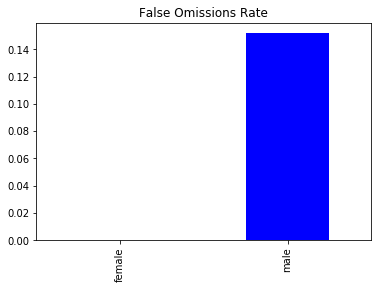

In [91]:
_ = metrics_frame['False Omissions Rate'].plot(kind='bar', color='b', title='False Omissions Rate')

In this model, no female is predicted to not survive but actually survived, so The false omission for female is 0. 

#### Calculate and report disparity

In [92]:
parity_threshold_low = 0.8    # user-defined low threshold value
parity_threshold_hi = 1.25    # user-defined high threshold value


# small utility function to format pandas table output
def disparate_red(val):
    
    color = 'blue' if (parity_threshold_low < val < parity_threshold_hi) else 'red'
    return 'color: %s' % color 

# display results
disp_frame.style.applymap(disparate_red)

,Prevalence Ratio,Accuracy Ratio,True Positive Rate Ratio,Precision Ratio,Specificity Ratio,Negative Predicted Value Ratio,False Positive Rate Ratio,False Discovery Rate Ratio,False Negative Rate Ratio,False Omissions Rate Ratio
female,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
male,0.268330,0.970087,0.388889,0.618421,4.937956,0.848276,0.124899,2.611111,61111111111111122944.000000,15172413793103448064.000000


For the selected thresholds, the GBM has many out-of-range values for matrics, some of them are extremely large. The false omissions rate disparity indicates that the saying 'women and children first' once applied when the disaster happened.

#### Plot false omissions rate disparity

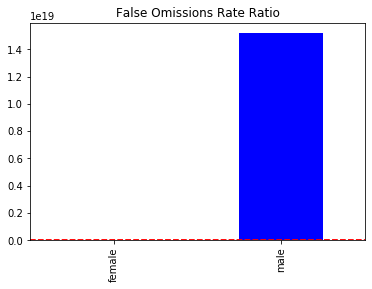

In [93]:
ax = disp_frame['False Omissions Rate Ratio'].plot(kind='bar', color='b', title='False Omissions Rate Ratio')
_ = ax.axhline(parity_threshold_low, color='r', linestyle='--')
_ = ax.axhline(parity_threshold_hi, color='r', linestyle='--')

The model is suffering from a huge disparity problem. It is suspected that the original data shows disparity, so the model is trained that way. More traditional fair lending measures will be assessed and, local, or individual, fairness will also be investigated. 

#### 6.3.3 Report confusion matrices by `Child`

In [94]:
child_levels = list(valid_yhat['Child'].unique())
child_levels

[0, 1]

#### Confusion matrix for `Child = 0`

In [95]:
adult_cm = evaluate.get_confusion_matrix(valid_yhat, 'Survived', 'p_Survived', by='Child', level=0, cutoff=best_cut)
adult_cm

,actual: 1,actual: 0
predicted: 1,76,28
predicted: 0,20,121


#### Confusion matrix for `Child = 1`

In [96]:
child_cm = evaluate.get_confusion_matrix(valid_yhat, 'Survived', 'p_Survived', by='Child', level=1, cutoff=best_cut)
child_cm

,actual: 1,actual: 0
predicted: 1,14,4
predicted: 0,2,6


Because the saying was 'women and children first', we take children, who were priviledged, as the reference level. Adults (age > 12) will be the protected level. 

In [97]:
child_cm_dict = {'adult': adult_cm, 'child': child_cm} # group fairness metrics are based on confusion matrices
child_metrics_frame, child_disp_frame = debug.get_metrics_ratios(child_cm_dict, 'child') # calculate metrics and ratios
child_metrics_frame # display results

,Prevalence,Accuracy,True Positive Rate,Precision,Specificity,Negative Predicted Value,False Positive Rate,False Discovery Rate,False Negative Rate,False Omissions Rate
adult,0.391837,0.804082,0.791667,0.730769,0.812081,0.858156,0.187919,0.269231,0.208333,0.141844
child,0.615385,0.769231,0.875000,0.777778,0.600000,0.750000,0.400000,0.222222,0.125000,0.250000


There are big gaps in some rates between two groups. It seems that the model is treating children (age < 12) and adults (age >= 12) as different groups.

#### Plot false omissions rate by `Child`

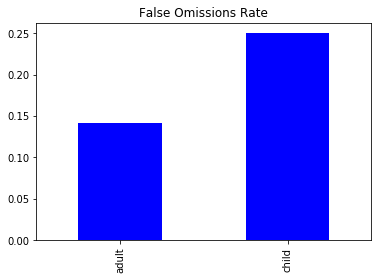

In [98]:
_ = child_metrics_frame['False Omissions Rate'].plot(kind='bar', color='b', title='False Omissions Rate')

#### Calculate and report disparity


In [99]:
parity_threshold_low = 0.8    # user-defined low threshold value
parity_threshold_hi = 1.25    # user-defined high threshold value


# small utility function to format pandas table output
def disparate_red(val):
    
    color = 'blue' if (parity_threshold_low < val < parity_threshold_hi) else 'red'
    return 'color: %s' % color 

# display results
child_disp_frame.style.applymap(disparate_red)

,Prevalence Ratio,Accuracy Ratio,True Positive Rate Ratio,Precision Ratio,Specificity Ratio,Negative Predicted Value Ratio,False Positive Rate Ratio,False Discovery Rate Ratio,False Negative Rate Ratio,False Omissions Rate Ratio
adult,0.636735,1.045306,0.904762,0.939560,1.353468,1.144208,0.469799,1.211538,1.666667,0.567376
child,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


For the selected thresholds, the GBM has many out-of-range values for children metrics, but the disparity is smaller than for the gender metrics. The false omissions rate disparity indicates that children got much more chances than adults to survive. 

#### Plot false omissions rate disparity

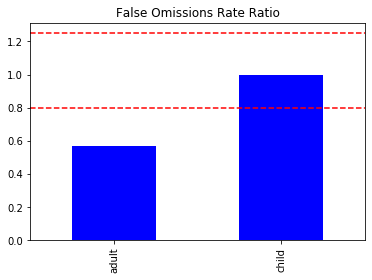

In [100]:
ax = child_disp_frame['False Omissions Rate Ratio'].plot(kind='bar', color='b', title='False Omissions Rate Ratio')
_ = ax.axhline(parity_threshold_low, color='r', linestyle='--')
_ = ax.axhline(parity_threshold_hi, color='r', linestyle='--')

The model is suffering from a relatively severe disparity problem.

### 6.4 Traditional Fairness Measures

Adverse Impact Ratio (AIR), Marginal Effect and Standardized Mean Difference (SMD) are calculated and discussed here.

#### 6.4.1 Calculate adverse impact ratio (AIR)

In [101]:
print('Adverse impact ratio: %.3f' % debug.air(sex_cm_dict, 'female', 'male'))

Female proportion accepted: 0.041
Male proportion accepted: 0.838
Adverse impact ratio: 20.535


In [102]:
print('Adverse impact ratio: %.3f' % debug.air(child_cm_dict, 'child', 'adult'))

Child proportion accepted: 0.308
Adult proportion accepted: 0.576
Adverse impact ratio: 1.870


Here we see the both gender and children experiments have high AIR. In the gender experiment, male group has much higher accpetance rate than females group does. The AIR = 20.535 indicate severe discrimination.
In the children experiment, the disparity in the acceptance rate is relatively smaller. But the AIR = 1.87 is still not desired.

#### 6.4.2 Calculate marginal effect
Marginal effect describes the difference between the percent of the reference group awarded a loan and the percent of the protected group awarded a loan under a model.

In [103]:
print('Marginal effect: %.2f%%' % debug.marginal_effect(sex_cm_dict, 'female', 'male'))

Female accepted: 4.08%
Male accepted: 83.82%
Marginal effect: -79.73%


About 4.08% of adults are predicted to survive. About 30.77% of children are predicted to survive. This results in a marginal effect of 26.78%. 

Given that the marginal effect is negative, indicating that a higher percentage of individuals in the protected group survived than in the reference group. The magnitude of the marginal effect is also relatively large, another sign that discrimination concerning age is high under the model. 

In [104]:
print('Marginal effect: %.2f%%' % debug.marginal_effect(child_cm_dict, 'child', 'adult'))

Child accepted: 30.77%
Adult accepted: 57.55%
Marginal effect: -26.78%


About 30.77% of children are predicted to survive. About 57.55% of adults are predicted to survive. This results in a marginal effect of -26.78%. 

Given that the marginal effect is negative, indicating that a higher percentage of individuals in the protected group survived than in the reference group, this value would likely indicate a discrimination problem in most scenarios. The magnitude of the marginal effect is also relatively large, though smaller than in the gender experiment.

#### 6.4.3 Calculate standardized mean difference

In [105]:
valid_yhat1 = valid_yhat
valid_yhat1['Child'] = valid_yhat1['Child'].replace(0, 'adult')
valid_yhat1['Child'] = valid_yhat1['Child'].replace(1, 'child')
valid_yhat1['Sex'] = valid_yhat1['Sex'].replace(0, 'male')
valid_yhat1['Sex'] = valid_yhat1['Sex'].replace(1, 'female')
valid_yhat1

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Title,Family,Mother,Child,PassengerID,p_Survived
0,0,3,"Braund, Mr. Owen Harris",male,22,1,0,7.2500,Mr,2,0,adult,1,0.144183
1,0,1,"McCarthy, Mr. Timothy J",male,54,0,0,51.8625,Mr,1,0,adult,7,0.202709
2,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27,0,2,11.1333,Mrs,3,1,adult,9,0.579777
3,1,3,"Sandstrom, Miss. Marguerite Rut",female,4,1,1,16.7000,Miss,3,0,child,11,0.651678
4,1,1,"Bonnell, Miss. Elizabeth",female,58,0,0,26.5500,Miss,1,0,adult,12,0.866651
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266,0,3,"Vander Cruyssen, Mr. Victor",male,47,0,0,9.0000,Mr,1,0,adult,874,0.033049
267,0,3,"Rice, Mrs. William (Margaret Norton)",female,39,0,5,29.1250,Mrs,6,1,adult,886,0.348722
268,1,1,"Graham, Miss. Margaret Edith",female,19,0,0,30.0000,Miss,1,0,adult,888,0.940672
269,1,1,"Behr, Mr. Karl Howell",male,26,0,0,30.0000,Mr,1,0,adult,890,0.392458


In [106]:
print('Standardized Mean Difference: %.2f' % debug.smd(valid_yhat1, 'Sex', yhat_name, 'female', 'male'))

Female mean yhat: 0.70
Male mean yhat: 0.19
P_Survived std. dev.:  0.30
Standardized Mean Difference: -1.73


In the validation set, females receive a higher average probability to survive than do males. This is difference is above the 0.2 threshold for a small difference. SMD also points ot high disparity between men and women under this model.

In [107]:
print('Standardized Mean Difference: %.2f' % debug.smd(valid_yhat1, 'Child', yhat_name, 'child', 'adult'))

Child mean yhat: 0.50
Adult mean yhat: 0.36
P_Survived std. dev.:  0.30
Standardized Mean Difference: -0.48


In the validation set, children receive a higher average probability to survive than do adults. This is difference is above the 0.2 threshold for a small difference. SMD also points ot high disparity between children and adults under this model.

##  6.5 Investigate Individual Disparity - Gender

#### 6.5.1 Augment predictions with decisions and logloss residuals for males with false positive predictions

In [108]:
valid_yhat_female = valid_yhat1[valid_yhat1['Sex'] == 'male'].copy(deep=True)


valid_yhat_female['d_Survived'] = 0
valid_yhat_female.loc[valid_yhat_female[yhat_name] > best_cut, 'd_Survived'] = 1

valid_yhat_female['r_Survived'] = -valid_yhat_female[y_name]*np.log(valid_yhat_female[yhat_name]) -\
                       (1 - valid_yhat_female[y_name])*np.log(1 - valid_yhat_female[yhat_name]) 
    
valid_yhat_female_fp = valid_yhat_female[(valid_yhat_female[y_name] == 0) &\
                                         (valid_yhat_female['d_Survived'] == 1)]

#### 6.5.2 Plot logloss residuals


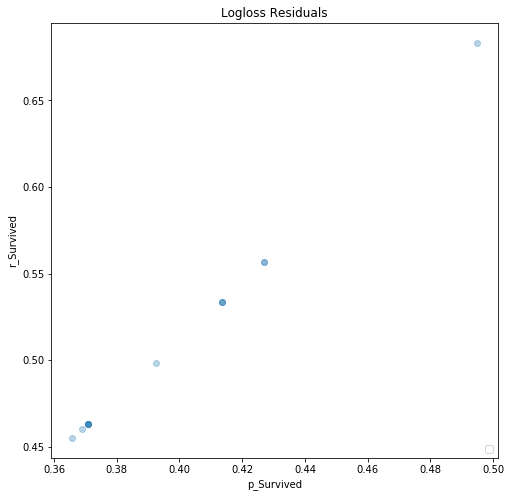

In [109]:
# initialize figure
fig, ax_ = plt.subplots(figsize=(8, 8))         

ax_.plot(valid_yhat_female_fp[yhat_name],
         valid_yhat_female_fp['r_Survived'],
         marker='o', linestyle='', alpha=0.3)

# annotate plot
_ = plt.xlabel(yhat_name)
_ = plt.ylabel('r_Survived')#### Examine low logloss residual individuals
_ = ax_.legend(loc=4)
_ = plt.title('Logloss Residuals')

#### 6.5.3 Examine low logloss residual individuals

In [110]:
valid_yhat_female_fp.sort_values(by='r_Survived', ascending=True)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Title,Family,Mother,Child,PassengerID,p_Survived,d_Survived,r_Survived
249,0,1,"Reuchlin, Jonkheer. John George",male,38,0,0,0.0000,Mr,1,0,adult,823,0.365609,1,0.455089
79,0,1,"Minahan, Dr. William Edward",male,44,2,0,90.0000,Mr,3,0,adult,246,0.368866,1,0.460236
65,0,1,"Rood, Mr. Hugh Roscoe",male,33,0,0,50.0000,Mr,1,0,adult,186,0.370826,1,0.463347
90,0,1,"Cairns, Mr. Alexander",male,33,0,0,31.0000,Mr,1,0,adult,271,0.370826,1,0.463347
97,0,1,"Smith, Mr. Richard William",male,33,0,0,26.0000,Mr,1,0,adult,285,0.370826,1,0.463347
108,0,1,"Williams-Lambert, Mr. Fletcher Fellows",male,33,0,0,35.0000,Mr,1,0,adult,352,0.370826,1,0.463347
181,0,1,"Harrington, Mr. Charles H",male,33,0,0,42.4000,Mr,1,0,adult,603,0.370826,1,0.463347
31,0,1,"Carrau, Mr. Francisco M",male,28,0,0,47.1000,Mr,1,0,adult,84,0.392458,1,0.498335
47,0,1,"Futrelle, Mr. Jacques Heath",male,37,1,0,53.1000,Mr,2,0,adult,138,0.413505,1,0.533591
91,0,1,"Natsch, Mr. Charles H",male,37,0,1,29.7000,Mr,2,0,adult,274,0.413505,1,0.533591


Examining the low-residual false positives, it can be seen that the cutoff selected by Youden's J is a bit too conservative.  This potential discrimination problem can be remediated by increasing the cutoff.

##  6.6 Investigate Individual Disparity - Child

#### 6.6.1 Augment predictions with decisions and logloss residuals adults with false positive predictions

In [111]:
valid_yhat_adult = valid_yhat1[valid_yhat1['Child'] == 'adult'].copy(deep=True)


valid_yhat_adult['d_Survived'] = 0
valid_yhat_adult.loc[valid_yhat_adult[yhat_name] > best_cut, 'd_Survived'] = 1

valid_yhat_adult['r_Survived'] = -valid_yhat_adult[y_name]*np.log(valid_yhat_adult[yhat_name]) -\
                       (1 - valid_yhat_adult[y_name])*np.log(1 - valid_yhat_adult[yhat_name]) 
    
valid_yhat_adult_fp = valid_yhat_adult[(valid_yhat_adult[y_name] == 0) &\
                                         (valid_yhat_adult['d_Survived'] == 1)]

#### 6.6.2 Plot logloss residuals

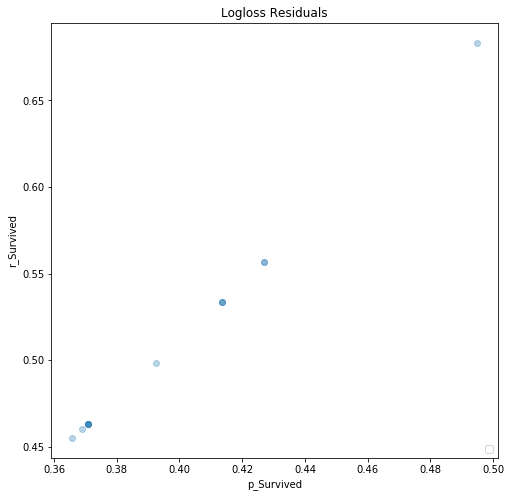

In [112]:
# initialize figure
fig, ax_ = plt.subplots(figsize=(8, 8))         

ax_.plot(valid_yhat_female_fp[yhat_name],
         valid_yhat_female_fp['r_Survived'],
         marker='o', linestyle='', alpha=0.3)

# annotate plot
_ = plt.xlabel(yhat_name)
_ = plt.ylabel('r_Survived')
_ = ax_.legend(loc=4)
_ = plt.title('Logloss Residuals')

#### 6.6.3 Examine low logloss residual individuals

In [113]:
valid_yhat_adult_fp.sort_values(by='r_Survived', ascending=True)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Title,Family,Mother,Child,PassengerID,p_Survived,d_Survived,r_Survived
267,0,3,"Rice, Mrs. William (Margaret Norton)",female,39,0,5,29.1250,Mrs,6,1,adult,886,0.348722,1,0.428819
174,0,3,"Caram, Mrs. Joseph (Maria Elias)",female,36,1,0,14.4583,Mrs,2,0,adult,579,0.359961,1,0.446226
249,0,1,"Reuchlin, Jonkheer. John George",male,38,0,0,0.0000,Mr,1,0,adult,823,0.365609,1,0.455089
79,0,1,"Minahan, Dr. William Edward",male,44,2,0,90.0000,Mr,3,0,adult,246,0.368866,1,0.460236
181,0,1,"Harrington, Mr. Charles H",male,33,0,0,42.4000,Mr,1,0,adult,603,0.370826,1,0.463347
65,0,1,"Rood, Mr. Hugh Roscoe",male,33,0,0,50.0000,Mr,1,0,adult,186,0.370826,1,0.463347
108,0,1,"Williams-Lambert, Mr. Fletcher Fellows",male,33,0,0,35.0000,Mr,1,0,adult,352,0.370826,1,0.463347
90,0,1,"Cairns, Mr. Alexander",male,33,0,0,31.0000,Mr,1,0,adult,271,0.370826,1,0.463347
97,0,1,"Smith, Mr. Richard William",male,33,0,0,26.0000,Mr,1,0,adult,285,0.370826,1,0.463347
31,0,1,"Carrau, Mr. Francisco M",male,28,0,0,47.1000,Mr,1,0,adult,84,0.392458,1,0.498335


Examining the low-residual false positives, it can be seen that the cutoff selected by Youden's J is a bit too conservative.  This potential discrimination problem can be remediated by increasing the cutoff.

# 7.Data Poisoning 

### 7.1 Download, Explore, and try to Poison some rows

#### 7.1.1 Import data and clean

In [114]:
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Title,Family,Mother,Child,PassengerID
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",1,38,1,0,71.2833,Mrs,2,0,0,2
2,1,3,"Heikkinen, Miss. Laina",1,26,0,0,7.9250,Miss,1,0,0,3
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35,1,0,53.1000,Mrs,2,0,0,4
4,0,3,"Allen, Mr. William Henry",0,35,0,0,8.0500,Mr,1,0,0,5
5,0,3,"Moran, Mr. James",0,33,0,0,8.4583,Mr,1,0,0,6


#### 7.1.2 Select some rows to poison 
we randomly select 10 rows of pclass=3,sex=0 and survived(depedent variable)=1 to poison 

In [115]:
# randomly select a small number of rows that can be changed easily
np.random.seed(SEED)
ids = np.random.choice(train[(train['Pclass'] == 3) & (train['Sex'] == 0) & (train['Survived'] == 1)].index, 10)
print(ids)

[ 74 146 803  65 127 220 804 804 146  74]


#### 7.1.3 Create rows of poisoned training data
Based on intimate knowledge of the training data, the adversary will change `Pclass` and `Fare` and `Child` feature values.so we assume that the adversary change pclass to 1.5,fare to 500 and survived to 0 for these 10 rows

In [116]:
# simple function for poisoning the selected rows
def poison(ids_):
    
    for i in ids_:
        
        train.loc[i, 'Pclass'] = 1.5
        train.loc[i, 'Child'] = 0.5
        train.loc[i, 'Fare'] = 500 
        train.loc[i, 'Survived'] = 0  
        
poison(ids)

poisoned = train.loc[ids, :] # reinsert poisoned data into training data
poisoned # display poisoned data

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Title,Family,Mother,Child,PassengerID
74,0,1.5,"Bing, Mr. Lee",0,32,0,0,500.0,Mr,1,0,0.5,75
146,0,1.5,"Andersson, Mr. August Edvard (""Wennerstrom"")",0,27,0,0,500.0,Mr,1,0,0.5,147
803,0,1.5,"Thomas, Master. Assad Alexander",0,0,0,1,500.0,Master,2,0,0.5,804
65,0,1.5,"Moubarek, Master. Gerios",0,5,1,1,500.0,Master,3,0,0.5,66
127,0,1.5,"Madsen, Mr. Fridtjof Arne",0,24,0,0,500.0,Mr,1,0,0.5,128
220,0,1.5,"Sunderland, Mr. Victor Francis",0,16,0,0,500.0,Mr,1,0,0.5,221
804,0,1.5,"Hedman, Mr. Oskar Arvid",0,27,0,0,500.0,Mr,1,0,0.5,805
804,0,1.5,"Hedman, Mr. Oskar Arvid",0,27,0,0,500.0,Mr,1,0,0.5,805
146,0,1.5,"Andersson, Mr. August Edvard (""Wennerstrom"")",0,27,0,0,500.0,Mr,1,0,0.5,147
74,0,1.5,"Bing, Mr. Lee",0,32,0,0,500.0,Mr,1,0,0.5,75


#### Assign modeling roles

### 7.2 Train GBM on Poisoned Data
`poisoned_gbm` is trained on the poisoned data. 

In [117]:
test["Survived"]=0 #add a column called "survived" for test in order to test the model

In [118]:
htrain = h2o.H2OFrame(train)
htrain[y_name] = htrain[y_name].asfactor()


htest = h2o.H2OFrame(test)
htest[y_name] = htest[y_name].asfactor()

# train
poisoned_gbm = model.gbm_grid(x_names, y_name, htrain, htest, SEED) # train

### 7.3 Load Pre-trained Monotonic GBM and Compare to Poisoned MGBM
Load the model known as `mgbm5` from the first lecture.

In [119]:
#load best_mgbm model
best_mgbm = h2o.load_model('best_mgbm')

#### Scores for best MGBM on poisoned data
When scoring the poisoned data using `best_mgbm`

In [120]:
best_mgbm.predict(h2o.H2OFrame(poisoned))

predict,p0,p1
0,0.77844,0.22156
0,0.77844,0.22156
1,0.417585,0.582415
1,0.403767,0.596233
0,0.77844,0.22156
0,0.713978,0.286022
0,0.77844,0.22156
0,0.77844,0.22156
0,0.77844,0.22156
0,0.77844,0.22156


#### Scores for GBM trained on poisoned data
When scoring the poisoned data using `poisoned_gbm`, maybe  the poisoned data gives surprisingly low probability to survive.it makes people cannot find the correct reason why passenger of titanic can survive. 

In [121]:
poisoned_gbm.predict(h2o.H2OFrame(poisoned)) 

predict,p0,p1
0,0.721079,0.278921
0,0.726223,0.273777
1,0.466259,0.533741
0,0.599782,0.400218
0,0.726223,0.273777
0,0.628865,0.371135
0,0.697794,0.302206
0,0.697794,0.302206
0,0.726223,0.273777
0,0.721079,0.278921


## 7.4  Try Adversarial Examples on our titanic data

#### 7.4.1 Generate random data to score with black box MGBM

In [122]:
# best guess at feature distributions,we assume that these columns are all normal distribution
schema_dict = {'Pclass': {'mean': 2, 'scale': 1, 'dist': 'normal'},
               'Sex': {'mean': 0, 'scale': 1, 'dist': 'normal'},
               'Age': {'mean': 30, 'scale': 13, 'dist': 'normal'},
               'Family': {'mean': 2, 'scale': 1, 'dist': 'normal'},
               'Mother': {'mean': 0, 'scale': 1, 'dist': 'normal'},
               'Child': {'mean': 0, 'scale': 1, 'dist': 'normal'},
               'Fare': {'min': 0, 'scale': 600, 'dist': 'exponential'}}

N = 600  # rows of simulated data

random_frame = pd.DataFrame(columns=list(schema_dict.keys())) 
                            
np.random.seed(SEED)   
    
for j in list(schema_dict.keys()): 
    
    if schema_dict[j]['dist'] == 'normal':
        random_frame[j] = np.random.normal(loc=schema_dict[j]['mean'],
                                           scale=schema_dict[j]['scale'], 
                                           size=N) 
    if schema_dict[j]['dist'] == 'exponential':
        random_frame[j] = schema_dict[j]['min'] + np.random.exponential(scale=schema_dict[j]['scale'], 
                                                                        size=N)

#### 7.4.2 Calculate partial dependence for each feature in black box MGBM

In [123]:
random_pd_ice_dict = {}

# calculate partial dependence for each selected feature
for xs in list(schema_dict.keys()): 
    random_pd_ice_dict[xs] = explain.pd_ice(xs, random_frame, best_mgbm)

#### 7.4.3 Find some percentiles of yhat in the validation data

In [124]:
# merge MGBM predictions onto random data
mgbm_yhat_random = pd.concat([random_frame.reset_index(drop=True),
                              best_mgbm.predict(h2o.H2OFrame(random_frame))['p1'].as_data_frame()],
                             axis=1)

# rename yhat column
mgbm_yhat_random = mgbm_yhat_random.rename(columns={'p1':'p_Survived'})

# find percentiles of predictions
mgbm_percentile_dict = explain.get_percentile_dict('p_Survived', mgbm_yhat_random, 'index')

mgbm_percentile_dict

{0: 200,
 99: 23,
 10: 584,
 20: 163,
 30: 111,
 40: 136,
 50: 583,
 60: 464,
 70: 505,
 80: 126,
 90: 272}

#### 7.4.4 Calculate ICE curve values

In [125]:
# loop through selected features
for xs in list(schema_dict.keys()): 

    # collect bins used in partial dependence
    bins = list(random_pd_ice_dict[xs][xs])
    
    # calculate ICE at percentiles 
    # using partial dependence bins
    # for each feature
    for i in sorted(mgbm_percentile_dict.keys()):
        col_name = 'Percentile_' + str(i)
        random_pd_ice_dict[xs][col_name] = explain.pd_ice(xs, 
                                                          pd.DataFrame(random_frame.loc[int(mgbm_percentile_dict[i]), :]).T, 
                                                          best_mgbm, 
                                                          bins=bins)['partial_dependence']

#### 7.4.5 View partial dependence and ICE for generated random data and black box MGBM
we can see from the ICE graph and partial dependence for different indepedent variable columns that Pclass presents a downward trend, and it is in line with the negative correlation between pclass and survived of the original train data.So do other columns.So the best guess at feature distributions are correct and can show the relationship and black box MGBM correctly

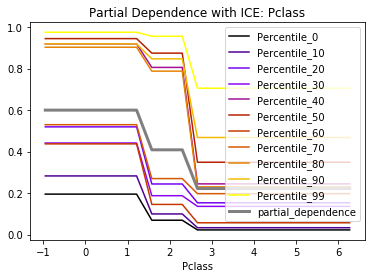

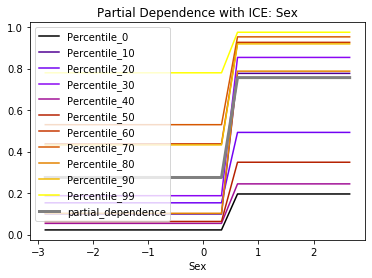

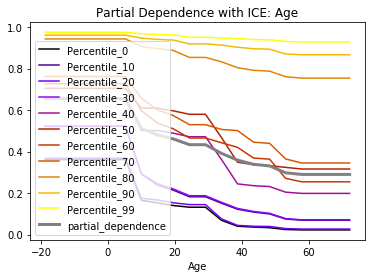

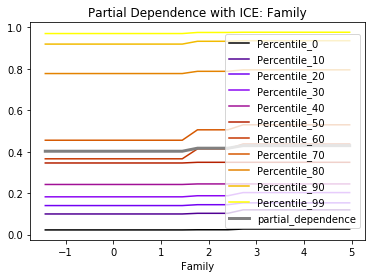

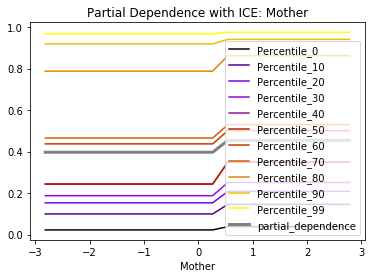

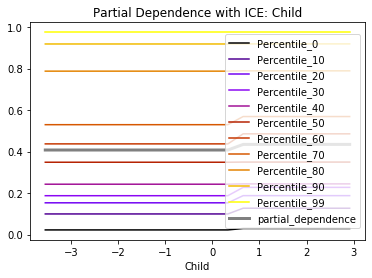

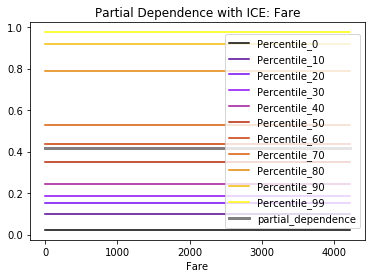

In [126]:
for xs in list(schema_dict.keys()): 
    explain.plot_pd_ice(xs, random_pd_ice_dict[xs])

#### 7.4.6 Generate potential adversarial examples
In the partial dependence and ICE results, it appears that the row at the 90th percentile of `p_Survived ` has the most natural variance under the model. The adversary will perturb this row of data thousands of time and submit the perturbed rows to the model to determine their affect on model predictions.

In [127]:
adversary_frame = pd.DataFrame(columns=list(schema_dict.keys()))
row = random_frame.iloc[mgbm_percentile_dict[90], :] # row selected from ICE plots

# we try four features:plcass ,family ,age and fare
for a in list(random_pd_ice_dict['Pclass']['Pclass']): 
        for b in list(random_pd_ice_dict['Family']['Family']):
            for c in list(random_pd_ice_dict['Age']['Age']):
                for d in list(random_pd_ice_dict['Fare']['Fare']):
                    row['Pclass'] = a
                    row['Family'] = b
                    row['Age'] = c
                    row['Fare'] = d
                    adversary_frame = adversary_frame.append(row, ignore_index=True, sort=False)

# get best_mgbm predictions on adversary_frame
adversary_frame['p_Survived'] = best_mgbm.predict(h2o.H2OFrame(adversary_frame)).as_data_frame()["p1"]

#### low scoring adversarial examples 
from these lowest scores rows ,the adversary could use to generate low probabilities of survive which can then influence the final model and give the wrong prediction for whether they can survive.

In [128]:
adversary_frame.sort_values(by='p_Survived').head(n=5) # 5 lowest scores

,Pclass,Sex,Age,Family,Mother,Child,Fare,p_Survived
160019,5.545841,1.038933,72.163250,-0.790063,-1.700201,0.628928,4217.634718,0.196283
161230,5.545841,1.038933,62.599789,0.167224,-1.700201,0.628928,2741.721201,0.196283
161229,5.545841,1.038933,62.599789,0.167224,-1.700201,0.628928,2530.876413,0.196283
161228,5.545841,1.038933,62.599789,0.167224,-1.700201,0.628928,2320.031625,0.196283
161227,5.545841,1.038933,62.599789,0.167224,-1.700201,0.628928,2109.186836,0.196283


#### high scoring adversarial examples
from these highest scores rows ,the adversary could use to generate low probabilities of survive which told people they can survive with some condition.But maybe it is wrong.And it influences the final model and give the wrong prediction for whether they can survive.

In [129]:
adversary_frame.sort_values(by='p_Survived').tail(n=5) # 5 highest scores

,Pclass,Sex,Age,Family,Mother,Child,Fare,p_Survived
41203,0.494031,1.038933,-9.126166,3.039083,-1.700201,0.628928,211.583743,0.969393
41204,0.494031,1.038933,-9.126166,3.039083,-1.700201,0.628928,422.428531,0.969393
41205,0.494031,1.038933,-9.126166,3.039083,-1.700201,0.628928,633.273319,0.969393
41199,0.494031,1.038933,-13.907896,3.039083,-1.700201,0.628928,3795.945142,0.969393
41643,0.494031,1.038933,-4.344435,3.358179,-1.700201,0.628928,0.738954,0.969393


#### Save Model

In [130]:
best_glm.model_id = 'best_glm'
h2o.save_model(best_glm, force=True)

'C:\\Users\\yuxia\\OneDrive\\Desktop\\Kaggle\\best_glm'

In [131]:
best_mgbm.model_id = 'best_mgbm'
h2o.save_model(best_mgbm, force=True)

'C:\\Users\\yuxia\\OneDrive\\Desktop\\Kaggle\\best_mgbm'

#### Shutdown H2O

In [132]:
# be careful, this can erase your work!
h2o.cluster().shutdown(prompt=True)

Are you sure you want to shutdown the H2O instance running at http://127.0.0.1:54321 (Y/N)? n
